# M3 Final Project

This project focuses on analyzing criminal offense data in Switzerland, leveraging machine learning techniques to uncover patterns and trends in the dataset provided by the Federal Statistical Office (FSO). The dataset, "Swiss Criminal Code (SCC): Offences and Accused Persons," spans from 2009 to 2023 and includes detailed records on criminal offenses and demographic information about accused individuals across Switzerland. By applying machine learning models to this dataset, we aim to generate insights that can enhance our understanding of criminal behavior and assist in identifying factors related to crime incidence. Ultimately, the findings from this project may inform more effective data-driven approaches in the fields of crime prevention and criminal justice.

**Authors:**
- Hazel Bunning
- Marcel Grosjean

# 1. Project setup

## Install the externals dependencies:

In [1]:
!pip install openpyxl # read/write Excel
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.6 MB/s eta 0:00:00


Import the libraries:

In [3]:
import pandas as pd
import pandas as pd

import numpy as np
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score
from openpyxl import load_workbook
import matplotlib.ticker as mticker
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tabulate import tabulate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from xgboost import XGBClassifier
from sklearn.cluster import KMeans

# 2. Import the dataset

The Federal Statistical Office (FSO) published an annual dataset detailing offenses and accused individuals under the Swiss Criminal Code (SCC) from 2009 to 2023. The information is part of the Police Crime Statistics and provides an overview of criminal offenses and demographics of accused persons within Switzerland. This dataset, themed around crime and criminal justice, is available in multiple languages and covers various spatial divisions across Switzerland. The data can be downloaded as an Excel file (580 kB) and is governed by the "OPEN-BY-ASK" terms, indicating some restrictions may apply for use or distribution.

https://www.bfs.admin.ch/bfs/en/home/aktuell/medienmitteilungen.assetdetail.30887740.html

We have downloaded the dataset titled "Swiss Criminal Code (SCC): Offences and Accused Persons" from the Federal Statistical Office page, covering data from 2009 to 2023. This dataset will be utilized to conduct a machine learning study aimed at analyzing patterns in criminal offenses and profiling accused individuals within Switzerland. The insights from this study may contribute to a better understanding of crime trends and support data-driven approaches in criminal justice.

## Download the source file

In [4]:
filename = "source_file.xlsx"

# URL of the data file
source_file_url = f"https://dam-api.bfs.admin.ch/hub/api/dam/assets/30887740/master"
response = requests.get(source_file_url)
response.raise_for_status()

# Store the file locally
with open(filename, "wb") as file:
  file.write(response.content)

!ls


sample_data  source_file.xlsx


## Parse, clean and save the data:
Some functions:

In [5]:
# return the int value of each cell
def parse_cell(val: str | None) -> int:
  if val is None:
    return 0
  try:
    x = int(val)
    return 0 if x < 0 else x
  except ValueError:
    return 0

We're now going to parse the excel file, extract all the relevant data, clean them and save them into the `df` dataframe.

In [6]:
# Create our empty dataset
headers = ["offence", "year", "male", "female", "non_binary", "legal_person",
           "natural_person", "-18", "18-29", "30-49", "50-69", "70+", "swiss",
           "permit", "asylium", "no_permit", "cases_failed", "cases_succeeded",
           "cases_total"]

# df is our final dataset that contains all the data
df = pd.DataFrame(columns=headers)

# read the source file and get all the tabs
workbook = load_workbook(filename=filename)
tab_names = workbook.sheetnames
# read sheet by sheet
for tab_name in tab_names:
  sheet = workbook[tab_name]
  year = parse_cell(tab_name)
  #print(f"Year: {year}")
  # read line by line (canton by canton)
  for row in range(0, 400):
    i = row + 7 # data start at line 6
    offence = sheet[f"A{i}"].value
    offence = re.sub(r"\s*\([^)]*\)$", "", offence)
    offence = offence.strip()

    if offence == "Total CC" or offence == "Offence - total":
      break

    if offence.startswith("Total"):
      continue

    new_row = {
      "offence": offence,
      "year": year,
      "male": parse_cell(sheet[f"J{i}"].value),
      "female": parse_cell(sheet[f"K{i}"].value),
      "non_binary": parse_cell(sheet[f"L{i}"].value),
      "legal_person": parse_cell(sheet[f"H{i}"].value),
      "natural_person": parse_cell(sheet[f"I{i}"].value),
      "-18": parse_cell(sheet[f"M{i}"].value) + parse_cell(sheet[f"N{i}"].value) + parse_cell(sheet[f"O{i}"].value),
      "18-29": parse_cell(sheet[f"P{i}"].value) + parse_cell(sheet[f"Q{i}"].value) + parse_cell(sheet[f"R{i}"].value),
      "30-49": parse_cell(sheet[f"S{i}"].value) + parse_cell(sheet[f"T{i}"].value) + parse_cell(sheet[f"U{i}"].value),
      "50-69": parse_cell(sheet[f"V{i}"].value) + parse_cell(sheet[f"W{i}"].value),
      "70+": parse_cell(sheet[f"X{i}"].value),
      "swiss": parse_cell(sheet[f"Z{i}"].value),
      "permit": parse_cell(sheet[f"AB{i}"].value),
      "asylium": parse_cell(sheet[f"AC{i}"].value),
      "no_permit": parse_cell(sheet[f"AD{i}"].value),
      "cases_failed": parse_cell(sheet[f"D{i}"].value),
      "cases_succeeded": parse_cell(sheet[f"C{i}"].value) - parse_cell(sheet[f"D{i}"].value),
      "cases_total": parse_cell(sheet[f"C{i}"].value),
    }

    # add the new row to the pd dataset
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

# we keep only the offence of 2023
#offences = df[df['year'] == 2023]['offence'].unique()

# we check each row of our df dataset and if the column is not in the array offences, we remove this line
#df = df[df['offence'].isin(offences)]

print(len(df))
df


3488


,offence,year,male,female,non_binary,legal_person,natural_person,-18,18-29,30-49,50-69,70+,swiss,permit,asylium,no_permit,cases_failed,cases_succeeded,cases_total
0,Homicides,2023,250,38,0,0,288,35,105,108,35,5,106,86,34,62,229,53,282
1,Homicide at the request of the victim,2023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
2,Inciting and assisting suicide,2023,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,2
3,Homicide through negligence,2023,34,13,0,0,47,1,13,22,8,3,32,11,1,3,3,41,44
4,Illegal abortion,2023,5,1,0,0,6,0,3,3,0,0,2,4,0,0,2,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3483,Reproduction of postage stamps without intent ...,2009,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3484,Breach of military secrecy,2009,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3485,Trading in material requisitioned by the armed...,2009,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3486,Unauthorised wearing of the military uniform,2009,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2


Let's make another dataframe but we group by type of offence:

In [ ]:
headers_group = ["offence", "year", "male", "female", "non_binary", "legal_person",
           "natural_person", "-18", "18-29", "30-49", "50-69", "70+", "swiss",
           "permit", "asylium", "no_permit", "cases_failed", "cases_succeeded",
           "cases_total"]

# df_group is our final dataset that contains all the data
df_group = pd.DataFrame(columns=headers_group)

# read the source file and get all the tabs
workbook = load_workbook(filename=filename)
tab_names = workbook.sheetnames
# read sheet by sheet
for tab_name in tab_names:
  sheet = workbook[tab_name]
  year = parse_cell(tab_name)
  #print(f"Year: {year}")
  # read line by line (canton by canton)
  for row in range(0, 400):
    i = row + 7 # data start at line 6
    offence = sheet[f"A{i}"].value
    offence = re.sub(r"\s*\([^)]*\)$", "", offence)
    offence = offence.strip()

    # end of tab
    if offence == "Total CC" or offence == "Offence - total":
      break

    # we only keep the total
    if not offence.startswith("Total Title"):
      continue

    #print(offence)
    new_row = {
      "offence": offence.split(":")[1].strip(),
      "year": year,
      "male": parse_cell(sheet[f"J{i}"].value),
      "female": parse_cell(sheet[f"K{i}"].value),
      "non_binary": parse_cell(sheet[f"L{i}"].value),
      "legal_person": parse_cell(sheet[f"H{i}"].value),
      "natural_person": parse_cell(sheet[f"I{i}"].value),
      "-18": parse_cell(sheet[f"M{i}"].value) + parse_cell(sheet[f"N{i}"].value) + parse_cell(sheet[f"O{i}"].value),
      "18-29": parse_cell(sheet[f"P{i}"].value) + parse_cell(sheet[f"Q{i}"].value) + parse_cell(sheet[f"R{i}"].value),
      "30-49": parse_cell(sheet[f"S{i}"].value) + parse_cell(sheet[f"T{i}"].value) + parse_cell(sheet[f"U{i}"].value),
      "50-69": parse_cell(sheet[f"V{i}"].value) + parse_cell(sheet[f"W{i}"].value),
      "70+": parse_cell(sheet[f"X{i}"].value),
      "swiss": parse_cell(sheet[f"Z{i}"].value),
      "permit": parse_cell(sheet[f"AB{i}"].value),
      "asylium": parse_cell(sheet[f"AC{i}"].value),
      "no_permit": parse_cell(sheet[f"AD{i}"].value),
      "cases_failed": parse_cell(sheet[f"D{i}"].value),
      "cases_succeeded": parse_cell(sheet[f"C{i}"].value) - parse_cell(sheet[f"D{i}"].value),
      "cases_total": parse_cell(sheet[f"C{i}"].value),
    }

    # add the new row to the pd dataset
    df_group = pd.concat([df_group, pd.DataFrame([new_row])], ignore_index=True)


df_group

,offence,year,male,female,non_binary,legal_person,natural_person,-18,18-29,30-49,50-69,70+,swiss,permit,asylium,no_permit,cases_failed,cases_succeeded,cases_total
0,Life and Limb,2023,16211,4758,0,5,20969,2703,5116,9344,3323,480,9826,8055,1312,1776,1085,26692,27777
1,Property,2023,32997,10613,3,141,43613,6645,13127,16744,6205,874,16776,11800,4178,10859,21769,333198,354967
2,Personal Honour and Breach of Secrecy or Privacy,2023,10146,3922,0,6,14068,1327,2849,6388,2980,515,7466,4912,564,1126,43,19644,19687
3,Liberty,2023,17085,3491,1,24,20577,2647,5171,8890,3329,533,8781,6252,1695,3849,984,67707,68691
4,Sexual Integrity,2023,4888,663,0,2,5551,1338,1459,1786,790,177,2877,1708,278,688,206,8317,8523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,Offences detrimental to Foreign Relations,2009,7,0,0,0,7,0,4,2,1,0,1,1,4,1,0,9,9
311,Administration of Justice,2009,1392,635,1,15,2028,248,598,770,345,44,958,558,59,453,30,1814,1844
312,Official or Professional Duty,2009,117,42,4,4,163,1,16,77,54,2,138,17,1,7,0,368,368
313,Bribery,2009,58,4,0,10,62,0,0,12,29,2,17,5,0,40,0,24,24


# EDA

Offences by type:

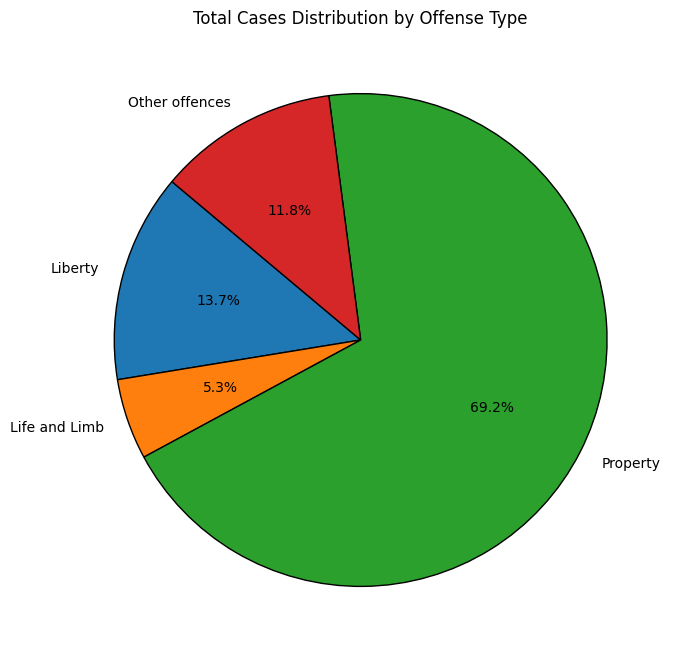

In [ ]:
# Grouping data by offense and summing the total cases
grouped_cases = df_group.groupby("offence")["cases_total"].sum()

# Calculating the 5% threshold
total_cases = grouped_cases.sum()
threshold = 0.05 * total_cases

# Filtering offenses below and above the 5% threshold
grouped_cases_filtered = grouped_cases[grouped_cases >= threshold]
other_cases_total = grouped_cases[grouped_cases < threshold].sum()

# Adding "Other offences" category
grouped_cases_filtered["Other offences"] = other_cases_total

# Plotting the pie chart with grouped "Other offences"
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(
    grouped_cases_filtered,
    labels=grouped_cases_filtered.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)
ax.set_title("Total Cases Distribution by Offense Type")
plt.show()

Offence by sex:

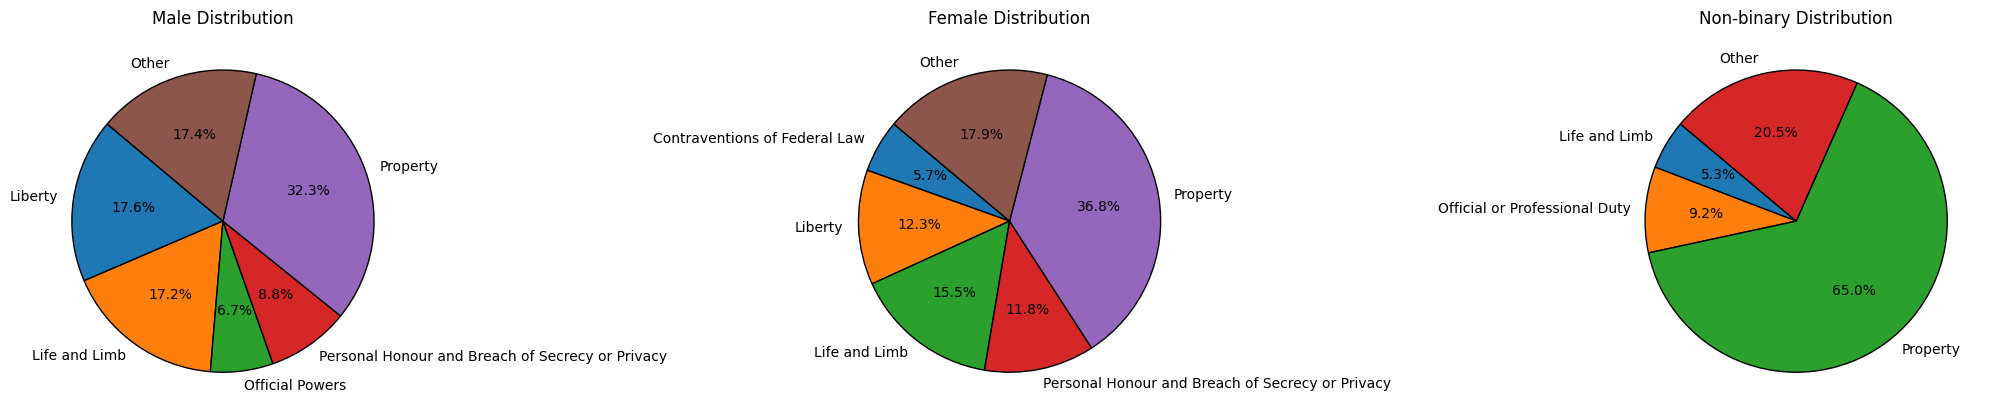

In [ ]:
# Function to group offenses with less than 10% of the total into an "Other" category
def group_offenses(data):
    pct = 0.05
    total = data.sum()
    grouped_data = data[data >= total * pct]  # Offenses that are >= 10% of the total
    other = data[data < total * pct].sum()    # Sum of offenses < 10% of the total
    if other > 0:
        grouped_data["Other"] = other         # Add "Other" category if applicable
    return grouped_data


# Grouping by offense for each gender category (no threshold grouping applied)
grouped_male = df_group.groupby("offence")["male"].sum()
grouped_female = df_group.groupby("offence")["female"].sum()
grouped_non_binary = df_group.groupby("offence")["non_binary"].sum()

# Apply the grouping function to each gender category
grouped_male = group_offenses(grouped_male)
grouped_female = group_offenses(grouped_female)
grouped_non_binary = group_offenses(grouped_non_binary)

# Plotting pie charts for each gender category
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# Male offenders pie chart
axs[0].pie(
    grouped_male,
    labels=grouped_male.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)
axs[0].set_title("Male Distribution")

# Female offenders pie chart
axs[1].pie(
    grouped_female,
    labels=grouped_female.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)
axs[1].set_title("Female Distribution")

# Non-binary offenders pie chart
axs[2].pie(
    grouped_non_binary,
    labels=grouped_non_binary.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)
axs[2].set_title("Non-binary Distribution")

plt.tight_layout()
plt.show()

Offences by age:

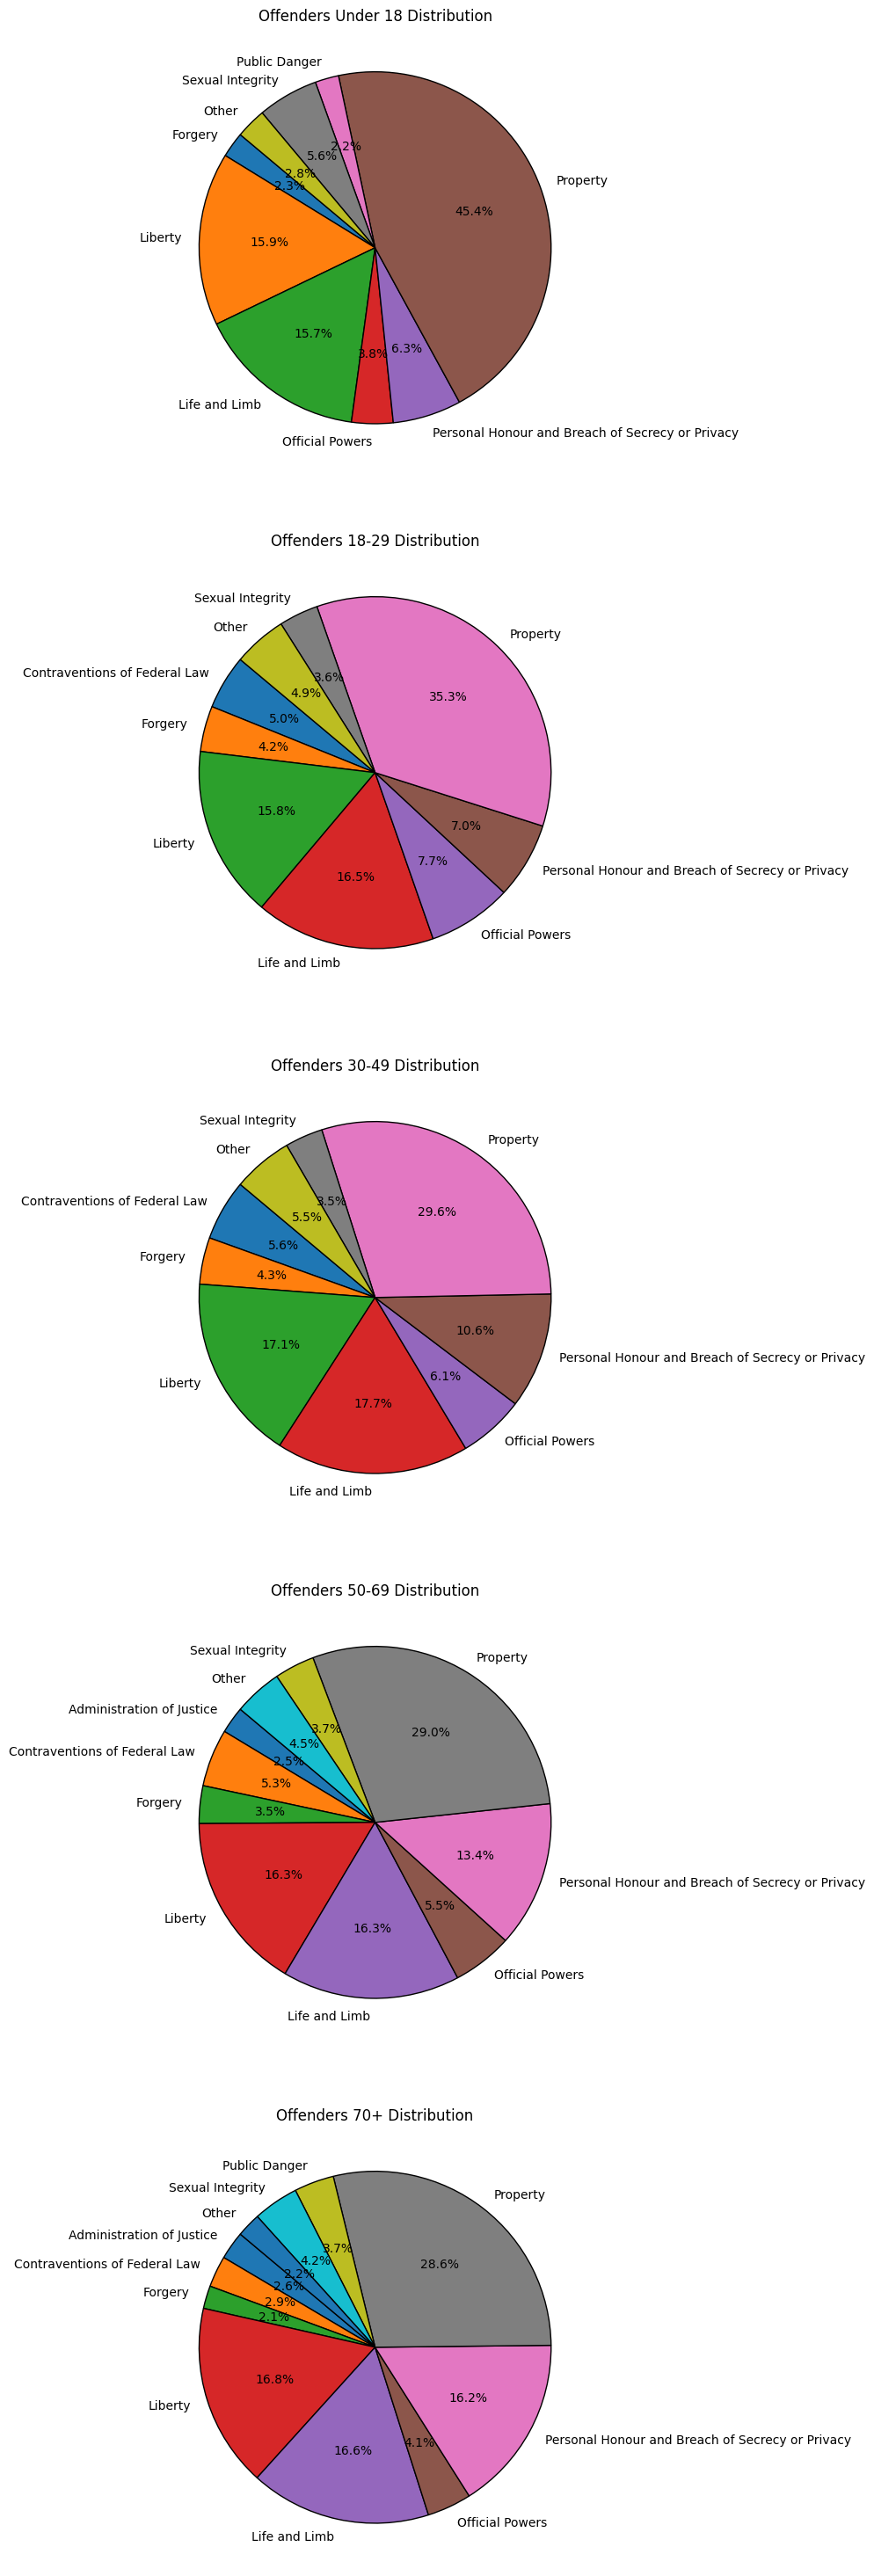

In [ ]:
# Function to group offenses with less than 10% of the total into an "Other" category
def group_offenses(data, pct=0.02):
    total = data.sum()
    grouped_data = data[data >= total * pct]  # Offenses that are >= pct of the total
    other = data[data < total * pct].sum()    # Sum of offenses < pct of the total
    if other > 0:
        grouped_data["Other"] = other         # Add "Other" category if applicable
    return grouped_data

# Group by offense and sum across all years for each age category
grouped_age_under_18 = df_group.groupby("offence")["-18"].sum()
grouped_age_18_29 = df_group.groupby("offence")["18-29"].sum()
grouped_age_30_49 = df_group.groupby("offence")["30-49"].sum()
grouped_age_50_69 = df_group.groupby("offence")["50-69"].sum()
grouped_age_70_plus = df_group.groupby("offence")["70+"].sum()

# Apply the grouping function to each age category
grouped_age_under_18 = group_offenses(grouped_age_under_18)
grouped_age_18_29 = group_offenses(grouped_age_18_29)
grouped_age_30_49 = group_offenses(grouped_age_30_49)
grouped_age_50_69 = group_offenses(grouped_age_50_69)
grouped_age_70_plus = group_offenses(grouped_age_70_plus)

# Plotting pie charts for each age category in a single column
fig, axs = plt.subplots(5, 1, figsize=(8, 30))

# Under 18 offenders pie chart
axs[0].pie(
    grouped_age_under_18,
    labels=grouped_age_under_18.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)
axs[0].set_title("Offenders Under 18 Distribution")

# 18-29 offenders pie chart
axs[1].pie(
    grouped_age_18_29,
    labels=grouped_age_18_29.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)
axs[1].set_title("Offenders 18-29 Distribution")

# 30-49 offenders pie chart
axs[2].pie(
    grouped_age_30_49,
    labels=grouped_age_30_49.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)
axs[2].set_title("Offenders 30-49 Distribution")

# 50-69 offenders pie chart
axs[3].pie(
    grouped_age_50_69,
    labels=grouped_age_50_69.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)
axs[3].set_title("Offenders 50-69 Distribution")

# 70+ offenders pie chart
axs[4].pie(
    grouped_age_70_plus,
    labels=grouped_age_70_plus.index,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)
axs[4].set_title("Offenders 70+ Distribution")

plt.tight_layout()
plt.show()

Sex v2

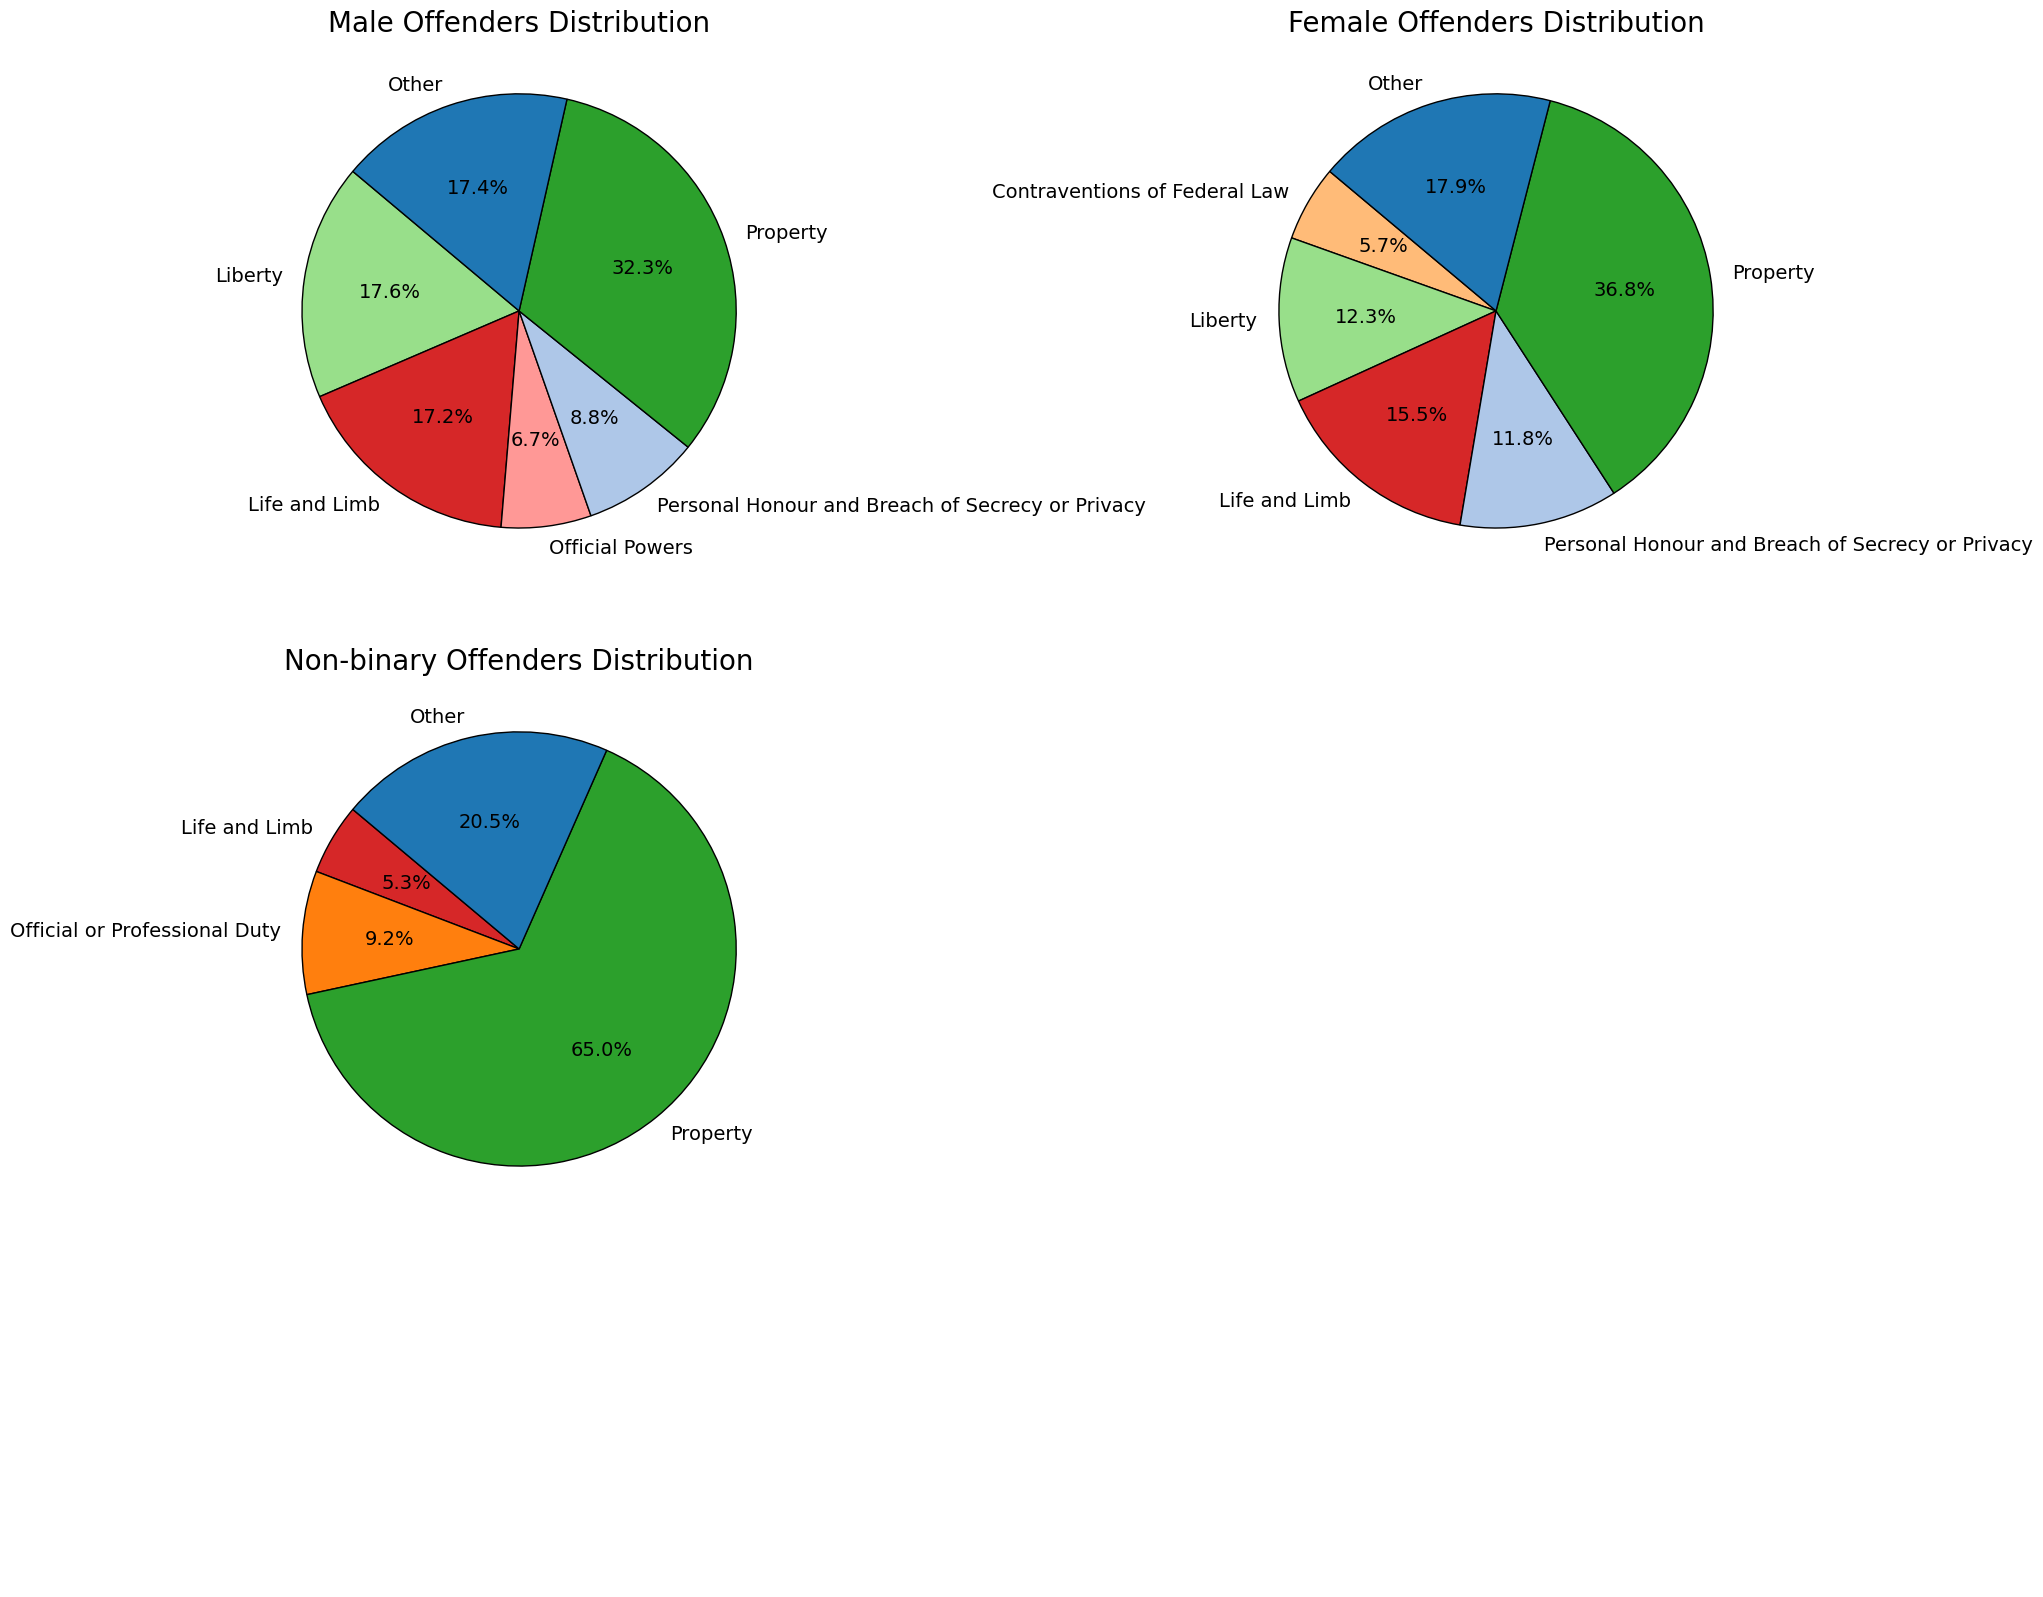

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming df_group is provided and structured similarly
# Example: df_group = pd.DataFrame(...)

# Function to group offenses with less than 5% of the total into an "Other" category
def group_offenses(data, pct=0.05):
    total = data.sum()
    grouped_data = data[data >= total * pct]  # Offenses that are >= pct of the total
    other = data[data < total * pct].sum()    # Sum of offenses < pct of the total
    if other > 0:
        grouped_data["Other"] = other         # Add "Other" category if applicable
    return grouped_data

# Group by offense and sum across all years for each gender category
grouped_male = df_group.groupby("offence")["male"].sum()
grouped_female = df_group.groupby("offence")["female"].sum()
grouped_non_binary = df_group.groupby("offence")["non_binary"].sum()

# Apply the grouping function to each gender category
grouped_male = group_offenses(grouped_male)
grouped_female = group_offenses(grouped_female)
grouped_non_binary = group_offenses(grouped_non_binary)

# Get a unique list of offenses across all gender groups
all_offenses = set(grouped_male.index) | set(grouped_female.index) | set(grouped_non_binary.index)

# Generate a consistent color map for each offense
color_map = {offense: plt.cm.tab20(i % 20) for i, offense in enumerate(all_offenses)}

# Function to get colors for offenses, ensuring consistency across gender groups
def get_colors(data, color_map):
    return [color_map[offense] for offense in data.index]

# Plotting pie charts for each gender category in a 2-row, 2-column grid
fig, axs = plt.subplots(2, 2, figsize=(20, 20))  # Larger figure size for better visibility

# Parameters for font sizes
title_font_size = 20
label_font_size = 14

# Male offenders pie chart
axs[0, 0].pie(
    grouped_male,
    labels=grouped_male.index,
    autopct=lambda p: f'{p:.1f}%' if p > 0 else '',
    startangle=140,
    wedgeprops={'edgecolor': 'black'},
    colors=get_colors(grouped_male, color_map),
    textprops={'fontsize': label_font_size}  # Increased label font size
)
axs[0, 0].set_title("Male Offenders Distribution", fontsize=title_font_size)

# Female offenders pie chart
axs[0, 1].pie(
    grouped_female,
    labels=grouped_female.index,
    autopct=lambda p: f'{p:.1f}%' if p > 0 else '',
    startangle=140,
    wedgeprops={'edgecolor': 'black'},
    colors=get_colors(grouped_female, color_map),
    textprops={'fontsize': label_font_size}  # Increased label font size
)
axs[0, 1].set_title("Female Offenders Distribution", fontsize=title_font_size)

# Non-binary offenders pie chart
axs[1, 0].pie(
    grouped_non_binary,
    labels=grouped_non_binary.index,
    autopct=lambda p: f'{p:.1f}%' if p > 0 else '',
    startangle=140,
    wedgeprops={'edgecolor': 'black'},
    colors=get_colors(grouped_non_binary, color_map),
    textprops={'fontsize': label_font_size}  # Increased label font size
)
axs[1, 0].set_title("Non-binary Offenders Distribution", fontsize=title_font_size)

# Hide the unused subplot (bottom right)
axs[1, 1].axis('off')

# Adjust layout to reduce space between rows and make pie charts bigger
plt.tight_layout(pad=2.0)
fig.subplots_adjust(hspace=-0.5, wspace=0.8)  # Reduced hspace for smaller vertical spacing

plt.show()



Age v2

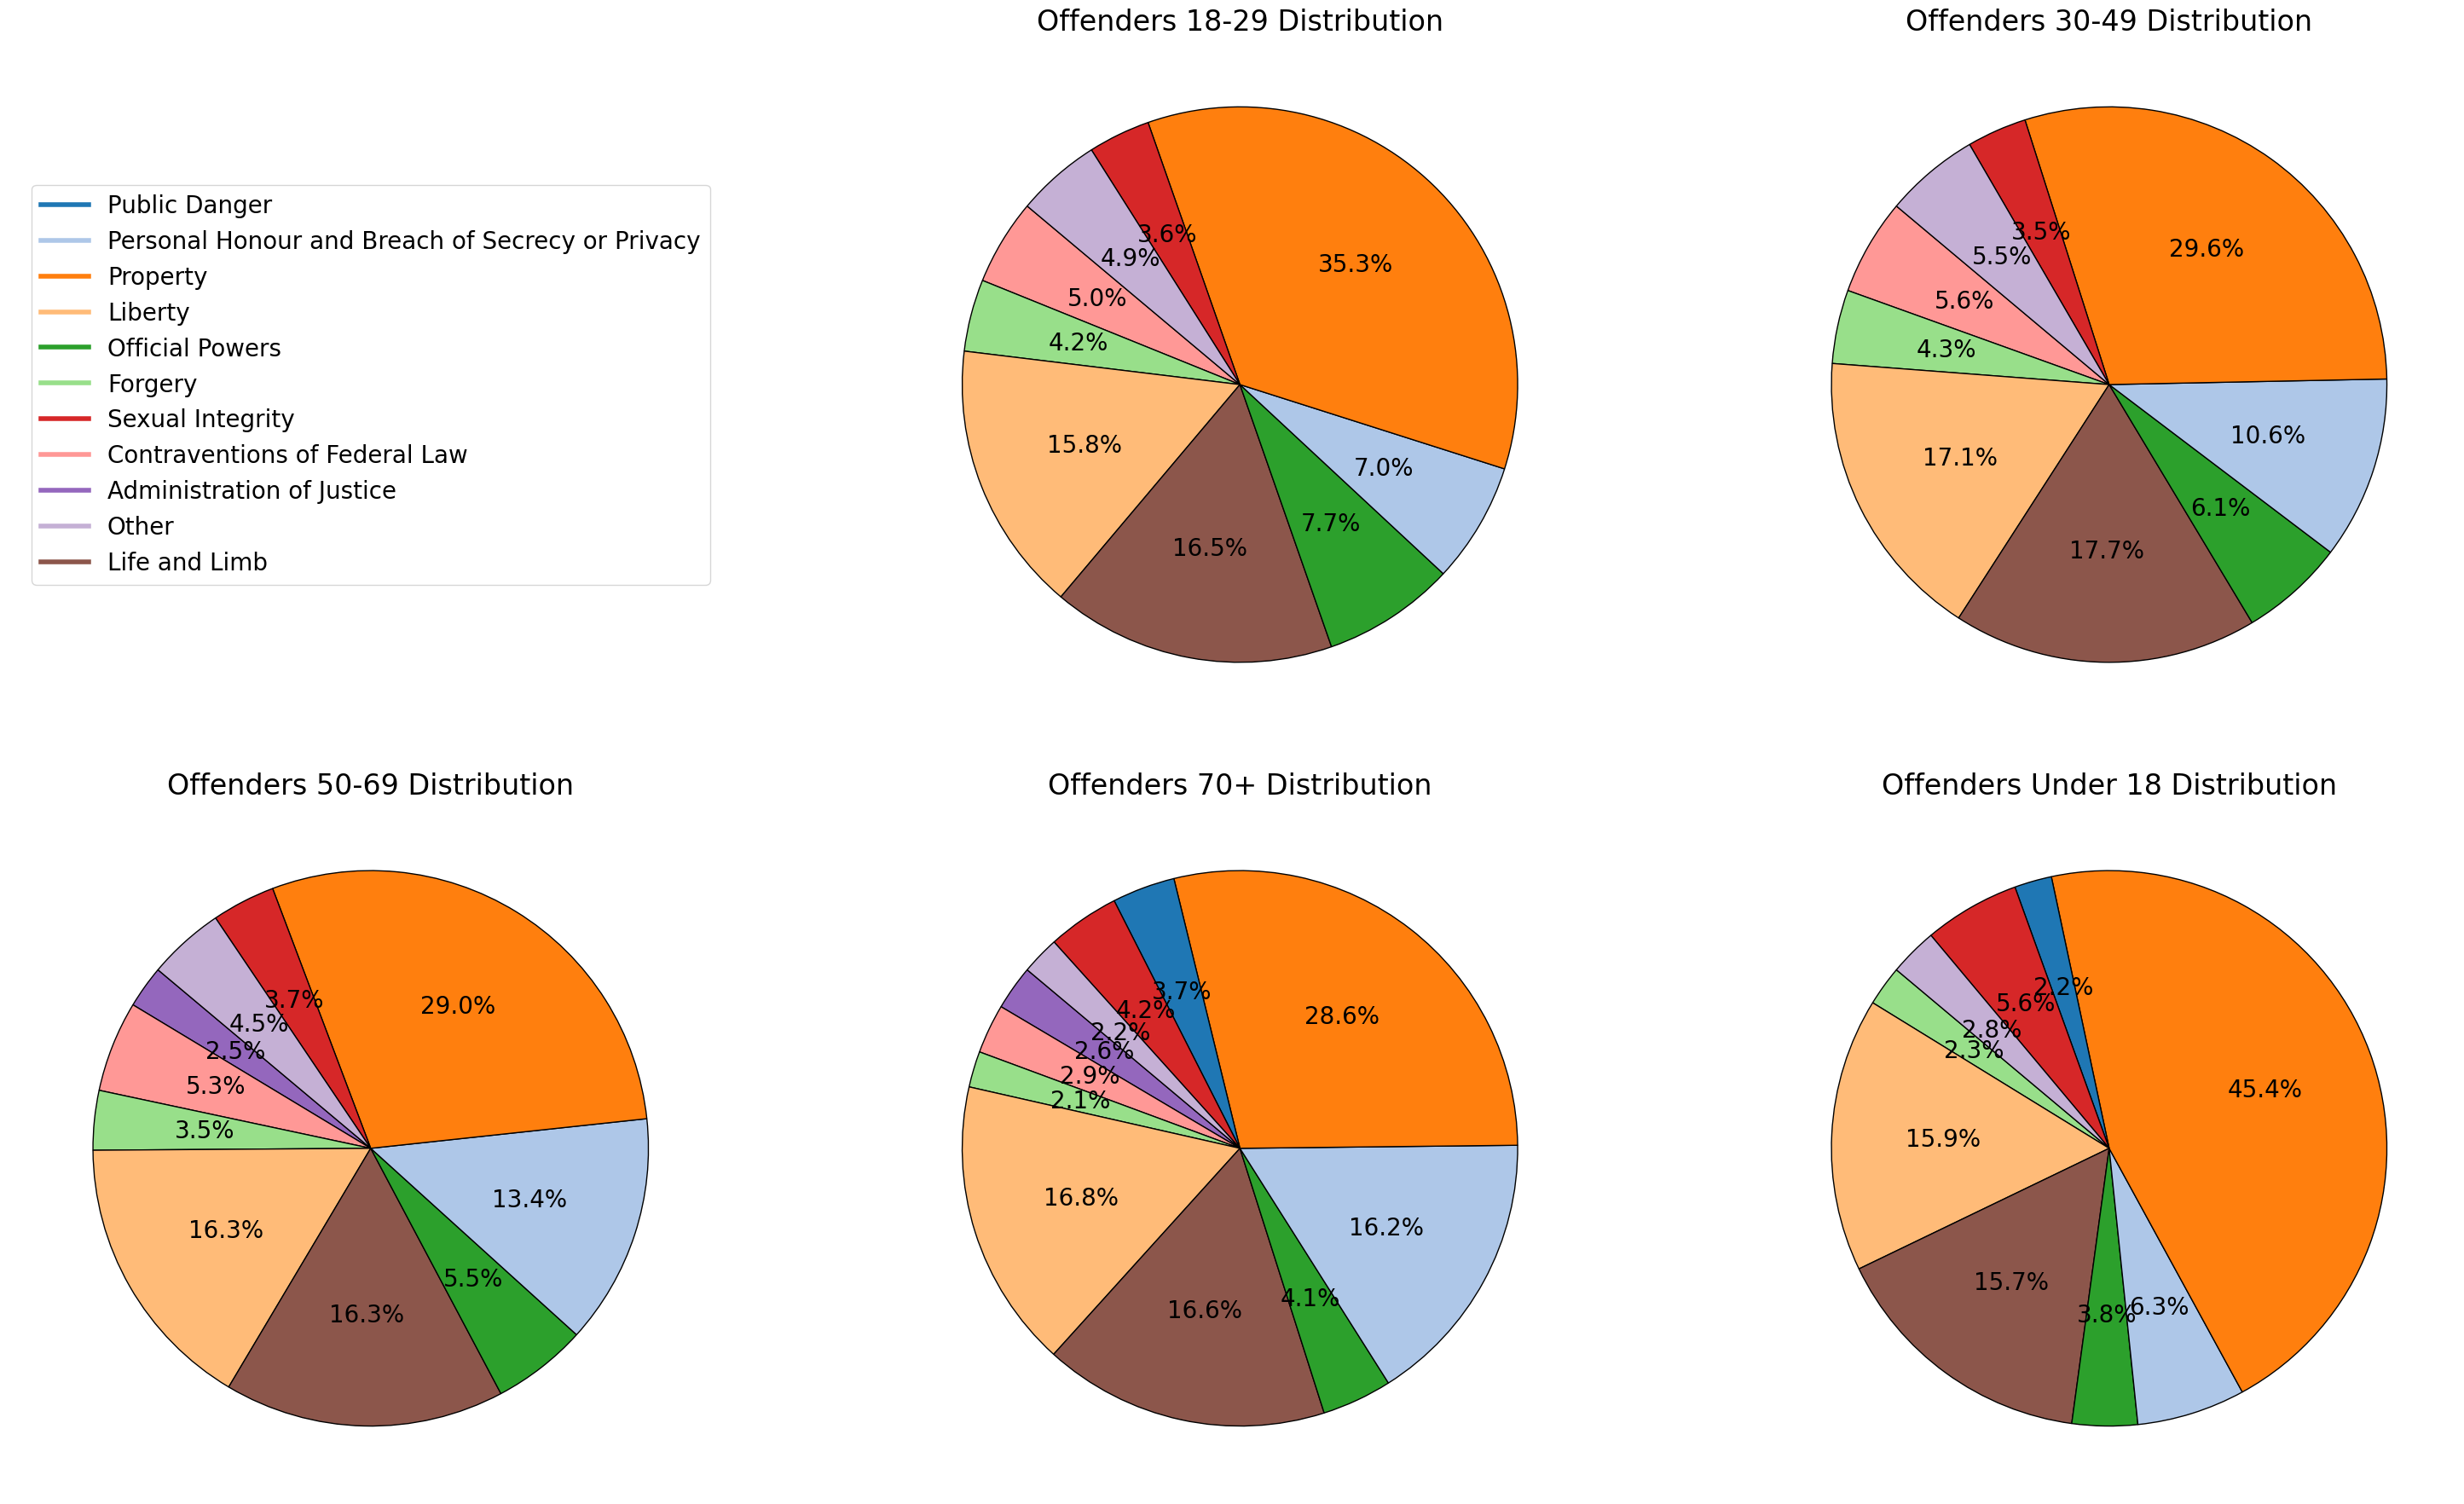

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming df_group is provided and structured similarly
# Example: df_group = pd.DataFrame(...)

# Function to group offenses with less than 10% of the total into an "Other" category
def group_offenses(data, pct=0.02):
    total = data.sum()
    grouped_data = data[data >= total * pct]  # Offenses that are >= pct of the total
    other = data[data < total * pct].sum()    # Sum of offenses < pct of the total
    if other > 0:
        grouped_data["Other"] = other         # Add "Other" category if applicable
    return grouped_data

# Group by offense and sum across all years for each age category
grouped_age_under_18 = df_group.groupby("offence")["-18"].sum()
grouped_age_18_29 = df_group.groupby("offence")["18-29"].sum()
grouped_age_30_49 = df_group.groupby("offence")["30-49"].sum()
grouped_age_50_69 = df_group.groupby("offence")["50-69"].sum()
grouped_age_70_plus = df_group.groupby("offence")["70+"].sum()

# Apply the grouping function to each age category
grouped_age_under_18 = group_offenses(grouped_age_under_18)
grouped_age_18_29 = group_offenses(grouped_age_18_29)
grouped_age_30_49 = group_offenses(grouped_age_30_49)
grouped_age_50_69 = group_offenses(grouped_age_50_69)
grouped_age_70_plus = group_offenses(grouped_age_70_plus)

# Get a unique list of offenses across all age groups
all_offenses = set(grouped_age_under_18.index) | set(grouped_age_18_29.index) | set(grouped_age_30_49.index) | set(grouped_age_50_69.index) | set(grouped_age_70_plus.index)

# Generate a color map for each offense
color_map = {offense: plt.cm.tab20(i % 20) for i, offense in enumerate(all_offenses)}

# Function to get colors for offenses, ensuring consistency across age groups
def get_colors(data, color_map):
    return [color_map[offense] for offense in data.index]

# Plotting pie charts for each age category in a 2-row, 3-column grid with larger figure size
fig, axs = plt.subplots(2, 3, figsize=(30, 18))  # Larger figure size for bigger pies

# Parameters for font sizes
title_font_size = 24
label_font_size = 20
autopct_font_size = 16
legend_font_size = 20  # Set legend font size to 20

# Adding a legend in the first subplot space
axs[0, 0].axis('off')  # Turn off the axis for the legend

# Adding a legend manually instead of using a table
handles = [plt.Line2D([0], [0], color=color_map[offense], lw=4) for offense in all_offenses]
axs[0, 0].legend(handles, all_offenses, fontsize=legend_font_size, loc='center')

# 18-29 offenders pie chart
axs[0, 1].pie(
    grouped_age_18_29,
    labels=None,  # No labels on pie chart
    autopct=lambda p: f'{p:.1f}%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'},
    colors=get_colors(grouped_age_18_29, color_map),
    textprops={'fontsize': label_font_size}  # Increase label font size
)
axs[0, 1].set_title("Offenders 18-29 Distribution", fontsize=title_font_size)

# 30-49 offenders pie chart
axs[0, 2].pie(
    grouped_age_30_49,
    labels=None,  # No labels on pie chart
    autopct=lambda p: f'{p:.1f}%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'},
    colors=get_colors(grouped_age_30_49, color_map),
    textprops={'fontsize': label_font_size}  # Increase label font size
)
axs[0, 2].set_title("Offenders 30-49 Distribution", fontsize=title_font_size)

# 50-69 offenders pie chart
axs[1, 0].pie(
    grouped_age_50_69,
    labels=None,  # No labels on pie chart
    autopct=lambda p: f'{p:.1f}%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'},
    colors=get_colors(grouped_age_50_69, color_map),
    textprops={'fontsize': label_font_size}  # Increase label font size
)
axs[1, 0].set_title("Offenders 50-69 Distribution", fontsize=title_font_size)

# 70+ offenders pie chart
axs[1, 1].pie(
    grouped_age_70_plus,
    labels=None,  # No labels on pie chart
    autopct=lambda p: f'{p:.1f}%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'},
    colors=get_colors(grouped_age_70_plus, color_map),
    textprops={'fontsize': label_font_size}  # Increase label font size
)
axs[1, 1].set_title("Offenders 70+ Distribution", fontsize=title_font_size)

# Under 18 offenders pie chart
axs[1, 2].pie(
    grouped_age_under_18,
    labels=None,  # No labels on pie chart
    autopct=lambda p: f'{p:.1f}%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'},
    colors=get_colors(grouped_age_under_18, color_map),
    textprops={'fontsize': label_font_size}  # Increase label font size
)
axs[1, 2].set_title("Offenders Under 18 Distribution", fontsize=title_font_size)

# Adjust layout to reduce space between rows and make pie charts bigger
plt.tight_layout(pad=2.0)
fig.subplots_adjust(hspace=0.1, wspace=0.2)  # Smaller vertical spacing between rows

plt.show()




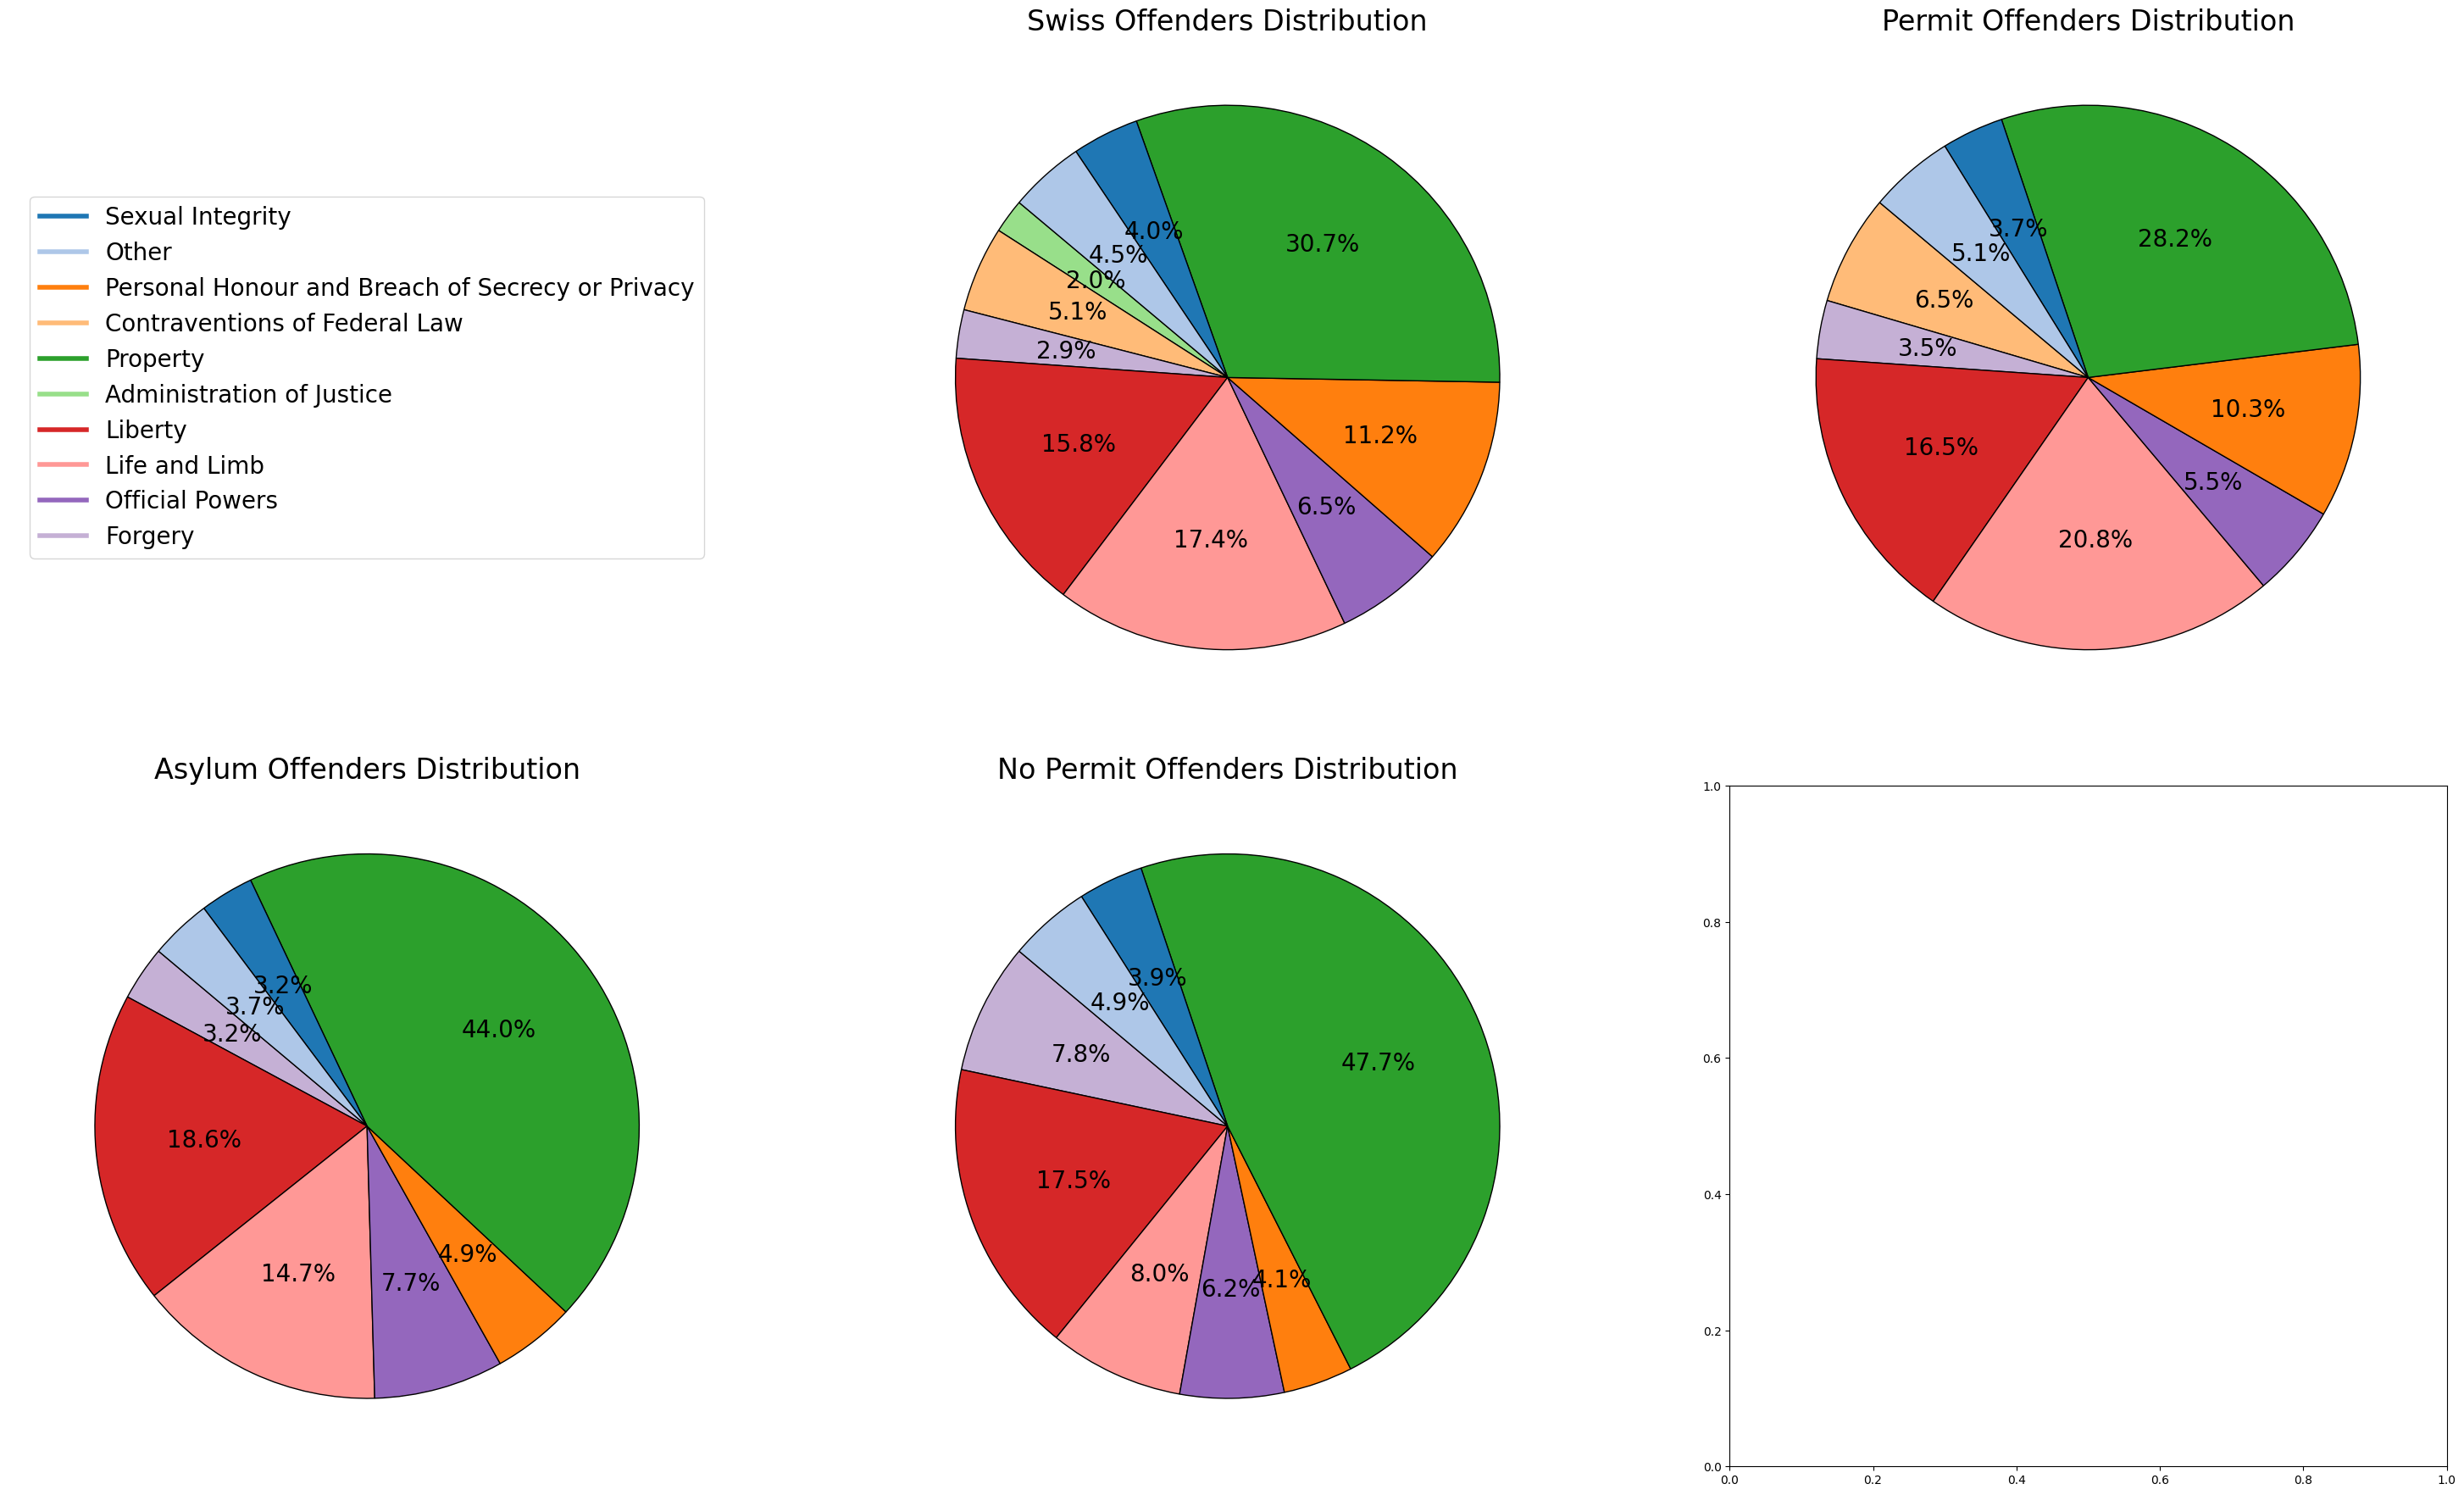

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming df_group is provided and structured similarly
# Example: df_group = pd.DataFrame(...)

# Function to group offenses with less than 10% of the total into an "Other" category
def group_offenses(data, pct=0.02):
    total = data.sum()
    grouped_data = data[data >= total * pct]  # Offenses that are >= pct of the total
    other = data[data < total * pct].sum()    # Sum of offenses < pct of the total
    if other > 0:
        grouped_data["Other"] = other         # Add "Other" category if applicable
    return grouped_data

# Group by offense and sum across all years for each residence status
grouped_swiss = df_group.groupby("offence")["swiss"].sum()
grouped_permit = df_group.groupby("offence")["permit"].sum()
grouped_asylum = df_group.groupby("offence")["asylium"].sum()
grouped_no_permit = df_group.groupby("offence")["no_permit"].sum()

# Apply the grouping function to each residence status category
grouped_swiss = group_offenses(grouped_swiss)
grouped_permit = group_offenses(grouped_permit)
grouped_asylum = group_offenses(grouped_asylum)
grouped_no_permit = group_offenses(grouped_no_permit)

# Get a unique list of offenses across all residence status groups
all_offenses = set(grouped_swiss.index) | set(grouped_permit.index) | set(grouped_asylum.index) | set(grouped_no_permit.index)

# Generate a color map for each offense
color_map = {offense: plt.cm.tab20(i % 20) for i, offense in enumerate(all_offenses)}

# Function to get colors for offenses, ensuring consistency across residence status groups
def get_colors(data, color_map):
    return [color_map[offense] for offense in data.index]

# Plotting pie charts for each residence status in a 2-row, 3-column grid with larger figure size
fig, axs = plt.subplots(2, 3, figsize=(30, 18))  # Larger figure size for bigger pies

# Parameters for font sizes
title_font_size = 24
label_font_size = 20
autopct_font_size = 16
legend_font_size = 20  # Set legend font size to 20

# Adding a legend in the first subplot space
axs[0, 0].axis('off')  # Turn off the axis for the legend

# Adding a legend manually instead of using a table
handles = [plt.Line2D([0], [0], color=color_map[offense], lw=4) for offense in all_offenses]
axs[0, 0].legend(handles, all_offenses, fontsize=legend_font_size, loc='center')

# Swiss offenders pie chart
axs[0, 1].pie(
    grouped_swiss,
    labels=None,  # No labels on pie chart
    autopct=lambda p: f'{p:.1f}%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'},
    colors=get_colors(grouped_swiss, color_map),
    textprops={'fontsize': label_font_size}  # Increase label font size
)
axs[0, 1].set_title("Swiss Offenders Distribution", fontsize=title_font_size)

# Permit offenders pie chart
axs[0, 2].pie(
    grouped_permit,
    labels=None,  # No labels on pie chart
    autopct=lambda p: f'{p:.1f}%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'},
    colors=get_colors(grouped_permit, color_map),
    textprops={'fontsize': label_font_size}  # Increase label font size
)
axs[0, 2].set_title("Permit Offenders Distribution", fontsize=title_font_size)

# Asylum offenders pie chart
axs[1, 0].pie(
    grouped_asylum,
    labels=None,  # No labels on pie chart
    autopct=lambda p: f'{p:.1f}%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'},
    colors=get_colors(grouped_asylum, color_map),
    textprops={'fontsize': label_font_size}  # Increase label font size
)
axs[1, 0].set_title("Asylum Offenders Distribution", fontsize=title_font_size)

# No Permit offenders pie chart
axs[1, 1].pie(
    grouped_no_permit,
    labels=None,  # No labels on pie chart
    autopct=lambda p: f'{p:.1f}%',
    startangle=140,
    wedgeprops={'edgecolor': 'black'},
    colors=get_colors(grouped_no_permit, color_map),
    textprops={'fontsize': label_font_size}  # Increase label font size
)
axs[1, 1].set_title("No Permit Offenders Distribution", fontsize=title_font_size)

# Adjust layout to reduce space between rows and make pie charts bigger
plt.tight_layout(pad=2.0)
fig.subplots_adjust(hspace=0.1, wspace=0.2)  # Smaller vertical spacing between rows

plt.show()




Offence type by nationality:

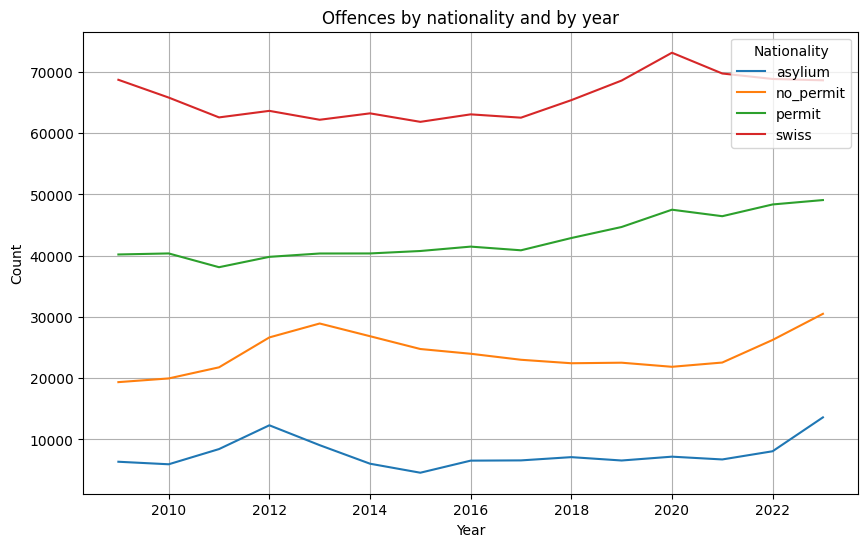

In [ ]:
# Melt the nationality columns to have 'year', 'nationality', and 'count' in each row
df_melted = df.melt(id_vars=['year'], value_vars=['swiss', 'permit', 'asylium', 'no_permit'],
                    var_name='nationality', value_name='count')

# Group by 'year' and 'nationality' and sum counts
df_grouped = df_melted.groupby(['year', 'nationality']).sum().reset_index()

# Pivot for plotting
df_pivot = df_grouped.pivot(index='year', columns='nationality', values='count')

# Plotting
plt.figure(figsize=(10, 6))
for nationality in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[nationality], label=nationality)

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Offences by nationality and by year')
plt.legend(title='Nationality')
plt.grid(True)
plt.show()


Offence type by year:

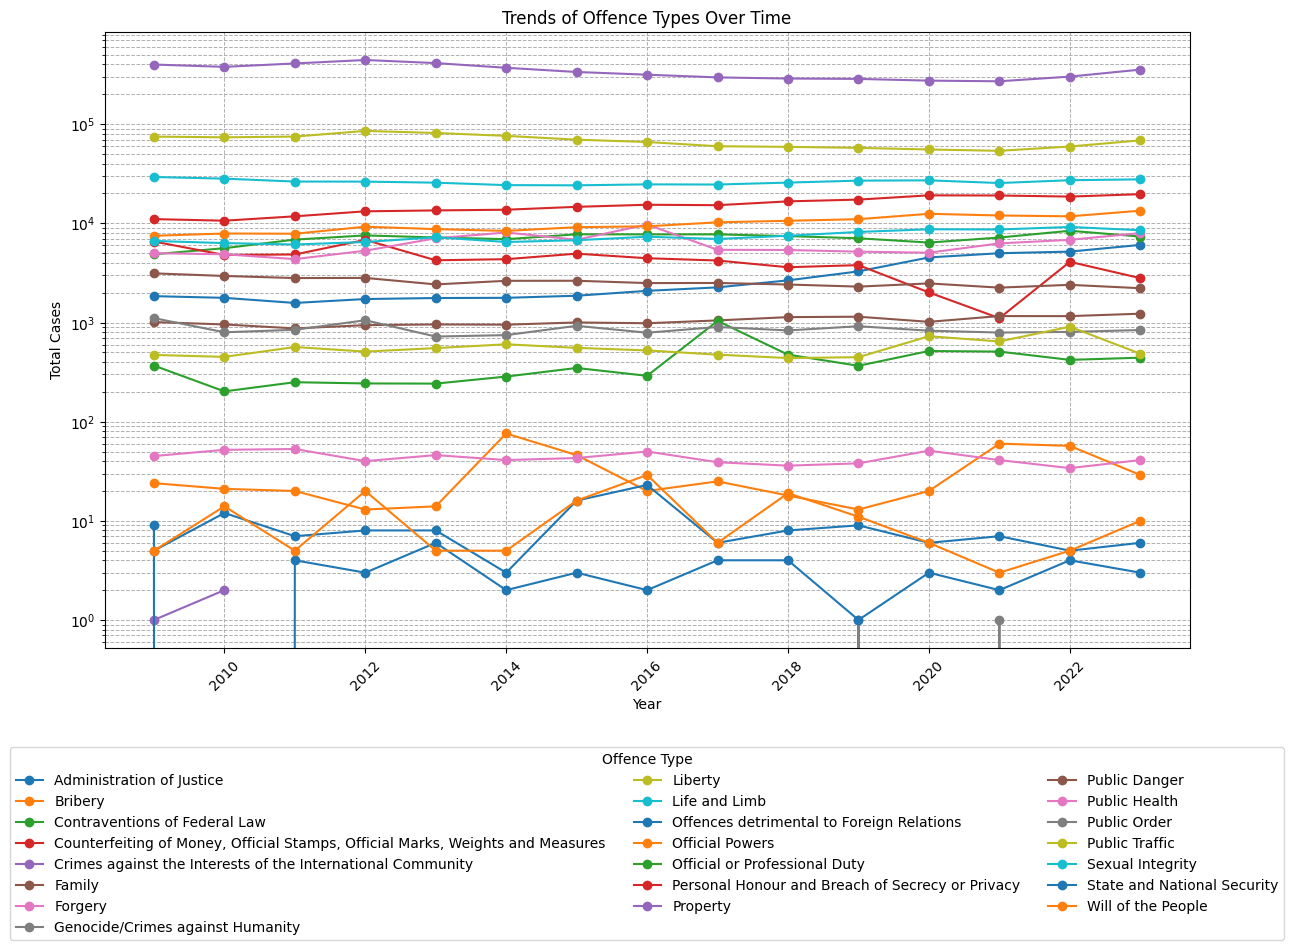

In [ ]:
# Grouping by 'year' and 'offence' to get the total cases per offense per year
offense_by_year = df_group.groupby(['year', 'offence'])['cases_total'].sum().unstack()

# Plotting the trends of each offense type over the years
plt.figure(figsize=(14, 8))
ax = offense_by_year.plot(ax=plt.gca(), marker='o')
plt.yscale('log')
plt.title("Trends of Offence Types Over Time")
plt.xlabel("Year")
plt.ylabel("Total Cases")
plt.xticks(rotation=45)

# Adding a grid to the plot
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.7)

# Moving the legend to the bottom of the graph
ax.legend(title="Offence Type", loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.show()

# Regressions

Let's try a many regressions models:

In [ ]:
def eval(model, model_name):
  # Initialize and train the linear regression model
  model.fit(X_train, y_train)

  # Make predictions on the test set
  y_pred = model.predict(X_test)

  # Evaluate the model
  print(f"Model: {model_name}")
  print("MSE:", mean_squared_error(y_test, y_pred))
  print("MAE:", mean_absolute_error(y_test, y_pred))
  print("R2:",  r2_score(y_test, y_pred))
  print()

X = df.iloc[:, 0:-1] # all the features
y = df["cases_total"] # dependant variable => number of cases

# encore offense and year
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse_output=False), [0])], remainder='passthrough')

# Transform X and convert it to a numpy array
X = np.array(ct.fit_transform(X))

# Split the dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# PCA
# Calculate optimal n_components based on explained variance
#target_variance = 0.95
#pca_temp = PCA().fit(X_train)
#cumulative_variance = np.cumsum(pca_temp.explained_variance_ratio_)
#optimal_n_components = np.argmax(cumulative_variance >= target_variance) + 1
# redure the dimentions
#pca = PCA(n_components = optimal_n_components)
#X_train = pca.fit_transform(X_train)
#X_test = pca.transform(X_test)
#print(f"optimal: {optimal_n_components}")

eval(LinearRegression(), "Multiple Linear Regression")
eval(DecisionTreeRegressor(random_state=42), "Decision Tree Regressor")
eval(RandomForestRegressor(random_state=42), "Random Forest Regressor")
eval(GradientBoostingRegressor(random_state=42), "XGBoost")

# Try predicting with ANN

# Building the ANN
model = Sequential()
model.add(Dense(units=18, activation='relu'))  # First hidden layer
model.add(Dense(units=32, activation='relu'))  # Second hidden layer
model.add(Dense(units=1, activation='linear'))  # Output layer for regression

# Compile the ANN
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the ANN
y_train = y_train.astype(float).values
y_test = y_test.astype(float).values
model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2, verbose = 0)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

Model: Multiple Linear Regression
MSE: 211.33890632505162
MAE: 0.7779906195448597
R2: 0.999997237594011

Model: Decision Tree Regressor
MSE: 527177.1833810888
MAE: 122.78510028653295
R2: 0.9931092791481954

Model: Random Forest Regressor
MSE: 525705.8326451291
MAE: 114.91276504297997
R2: 0.9931285111398601

Model: XGBoost
MSE: 179109.52163042905
MAE: 82.23713884455063
R2: 0.9976588635579029

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE: 944370.2747678702
MAE: 316.48012517473757
R2: 0.9876561578359068


Let's predict the future !

In [ ]:
# get all the offenses
offences = df["offence"].unique()
# get df headers except the first and last one
features = list(df.columns[2:-1])
# create an array containing all the linear models for every offence and feature

print(len(offences))
print(len(features))

lmodels = {}

for offense in offences:
  for feature in features:
    data = df[df["offence"] == offense][["year", feature]]

    X = data["year"].values.reshape(-1, 1)
    y = data[feature].values.reshape(-1, 1)

    regressor = LinearRegression()
    regressor.fit(X, y)

    lmodels[(offense, feature)] = regressor


249
16


In [ ]:
# Generate predicted data from 2024 to 2030
predicted_features = pd.DataFrame()
for year in range(2024, 2031):
  print(year)
  for offence in offences:
    # copy the first line of df
    new_row = df.iloc[0].copy()
    new_row = new_row.to_frame().T
    # remove last column
    new_row = new_row.iloc[:, :-1]
    # reset all the valeus to 0
    new_row.loc[:, :] = 0

    new_row["offence"] = offence
    new_row["year"] = year

    for feature in features:
      new_row[feature] = lmodels[(offence, feature)].predict(np.array(year).reshape(-1, 1))

    predicted_features = pd.concat([predicted_features, new_row])

predicted_features

2024
2025
2026
2027
2028
2029
2030


,offence,year,male,female,non_binary,legal_person,natural_person,-18,18-29,30-49,50-69,70+,swiss,permit,asylium,no_permit,cases_failed,cases_succeeded
0,Homicides,2024,215.419048,32.971429,0.0,0.00000,248.390476,30.190476,84.019048,93.638095,32.980952,7.561905,100.961905,79.676190,22.152381,45.600000,193.657143,45.400000
0,Homicide at the request of the victim,2024,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.019048,1.438095
0,Inciting and assisting suicide,2024,2.104762,0.980952,0.0,0.00000,3.085714,1.085714,0.247619,1.323810,0.428571,0.000000,1.971429,0.800000,0.000000,0.190476,3.057143,1.695238
0,Homicide through negligence,2024,38.714286,14.238095,0.0,-0.07619,52.952381,1.161905,9.638095,25.419048,14.628571,2.104762,36.028571,12.200000,0.238095,4.485714,2.057143,52.076190
0,Illegal abortion,2024,4.247619,0.580952,0.0,0.00000,4.828571,-0.019048,2.619048,2.161905,0.066667,0.000000,1.247619,3.057143,-0.085714,0.533333,1.666667,3.933333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Violation of a occupational ban,2030,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.256757
0,Exploitation of knowledge of confidential facts,2030,21.500000,6.300000,0.0,2.10000,27.800000,0.000000,-1.700000,20.100000,3.300000,4.000000,13.400000,7.300000,0.000000,4.200000,0.000000,8.100000
0,Price manipulation,2030,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000
0,Breach of professional confidentiality in medi...,2030,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


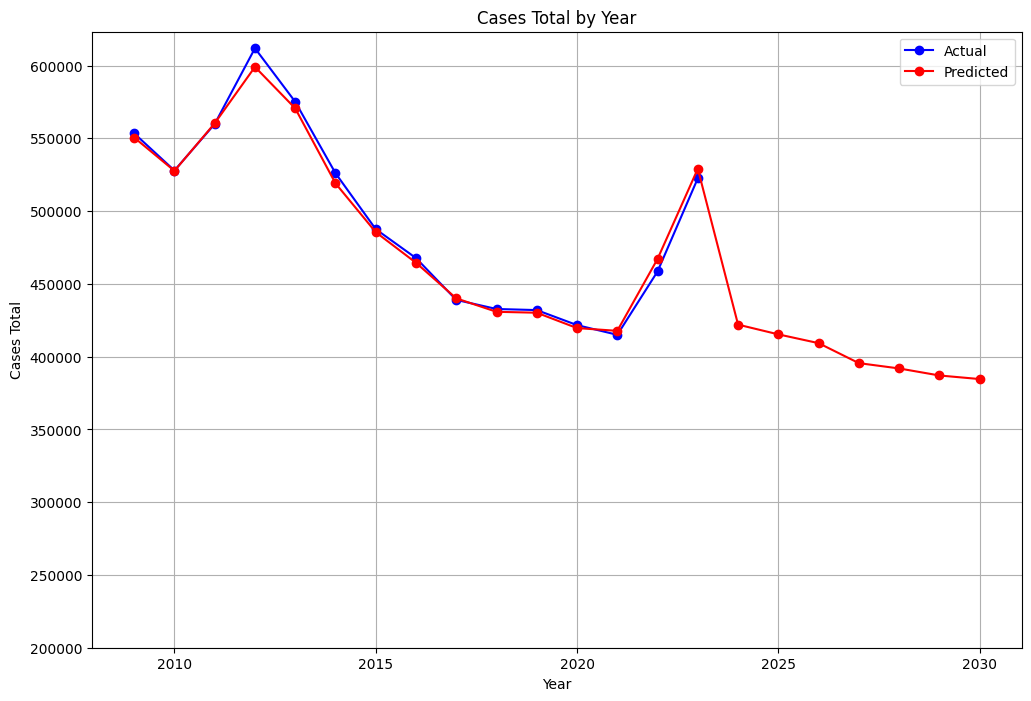

In [ ]:
# Select features and target
X = df.iloc[:, 0:-1]
y = df["cases_total"]

# Encode the first column and transform X
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse_output=False), [0])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

#print("MSE:", mean_squared_error(y_test, y_pred))
#print("MAE:", mean_absolute_error(y_test, y_pred))
#print("R2:",  r2_score(y_test, y_pred))
#print()

# Initialize lists for the plot
year_values = []
cases_totals = []
year_values_predict = []
cases_totals_predict = []

# Plot existing data
years = np.sort(df["year"].unique())
for year in years:
    X_year = df[df["year"] == year]
    y_year = X_year["cases_total"]
    year_values.append(year)
    cases_totals.append(y_year.sum())

# Predict for each year
for year in range(2009, 2024):
    X_year = df[df["year"] == year].iloc[:, 0:-1]
    X_year = np.array(ct.transform(X_year))  # Apply the trained transformer
    X_year = sc.transform(X_year)  # Apply the trained scaler

    predictions = model.predict(X_year)
    year_values_predict.append(year)
    cases_totals_predict.append(predictions.sum())

#########################################

# Extend predictions to future years
future_years = range(2024, 2031)  # Years from 2024 to 2030
future_predictions = []

for year in future_years:
    # Create a new DataFrame for the given year with average or default values for other features
    future_data = predicted_features[predicted_features["year"] == year].copy()  # Use 2023 as a reference year
    #future_data["year"] = year  # Update year
    #X_future = future_data.iloc[:, 0:-1]

    # Transform the data using the trained transformer and scaler
    X_future = np.array(ct.transform(future_data))  # Apply the trained transformer
    X_future = sc.transform(X_future)  # Apply the trained scaler

    # Predict using the trained model
    predictions = model.predict(X_future)
    future_predictions.append(predictions.sum())  # Sum predictions for all offenses in the year

# Combine predicted values with existing predictions
year_values_predict.extend(future_years)
cases_totals_predict.extend(future_predictions)



"""
# Extend predictions to future years
future_years = range(2024, 2031)  # Years from 2024 to 2030
future_predictions = []

for year in future_years:
    # Create a new DataFrame for the given year with average or default values for other features
    future_data = df[df["year"] == 2023].copy()  # Use 2023 as a reference year
    future_data["year"] = year  # Update year
    X_future = future_data.iloc[:, 0:-1]

    # Transform the data using the trained transformer and scaler
    X_future = np.array(ct.transform(X_future))  # Apply the trained transformer
    X_future = sc.transform(X_future)  # Apply the trained scaler

    # Predict using the trained model
    predictions = model.predict(X_future)
    future_predictions.append(predictions.sum())  # Sum predictions for all offenses in the year

# Combine predicted values with existing predictions
year_values_predict.extend(future_years)
cases_totals_predict.extend(future_predictions)
"""
#########################################


# Plot results
plt.figure(figsize=(12, 8))
plt.plot(year_values, cases_totals, marker='o', color="blue", label="Actual")
plt.plot(year_values_predict, cases_totals_predict, marker='o', color="red", label="Predicted")
plt.ylim(bottom=200000)
plt.title("Cases Total by Year")
plt.xlabel("Year")
plt.ylabel("Cases Total")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
pip install statsmodels pmdarima

Predicted cases total for the year 2024: 456944.19
Predicted cases total for the year 2025: 457319.94
Predicted cases total for the year 2026: 457231.91
Predicted cases total for the year 2027: 457252.53
Predicted cases total for the year 2028: 457247.70


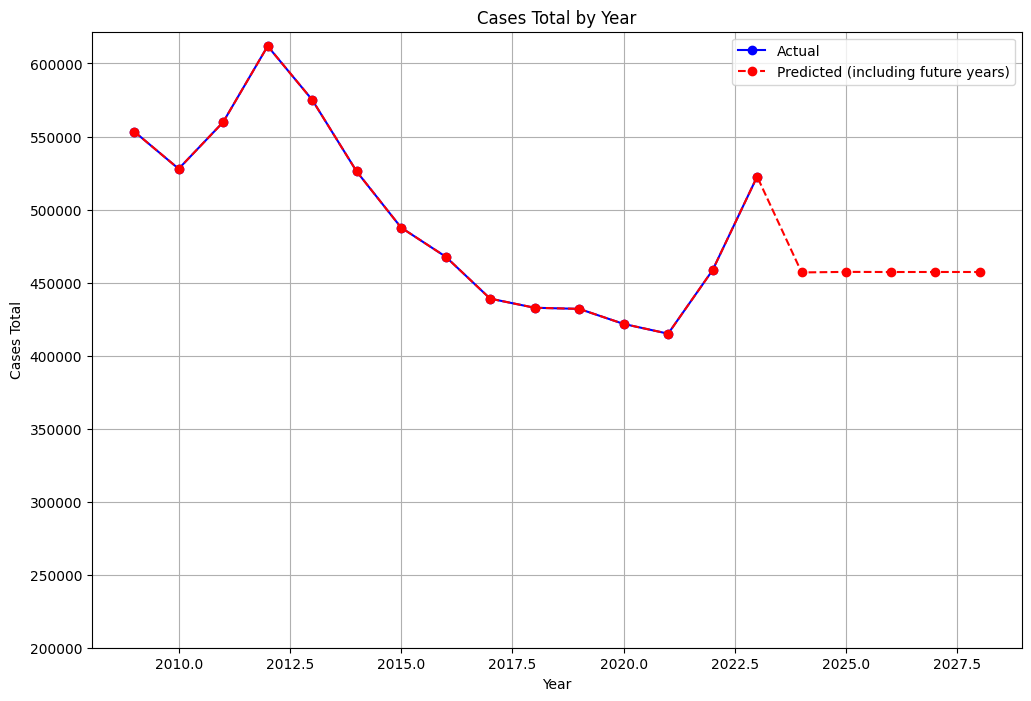

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# Assuming the dataset df is already loaded
# Aggregate data by year - Summing up "cases_total" for each year
df_yearly = df.groupby('year', as_index=False).sum()

# Set the year as index to prepare it as a time series
df_yearly.set_index('year', inplace=True)

# Prepare the time series data
y = df_yearly['cases_total']

# Convert the data to numeric, ensuring no dtype object issue
y = pd.to_numeric(y, errors='coerce')

# Check for and drop any NaN values if they exist after conversion
y = y.dropna()

# Split the data into train and test, using most of it for training
train = y[:-1]  # Training data until the second last year
test = y[-1:]   # Last year as test data

# Fit ARIMA Model (I am using ARIMA(1,1,1) for demonstration, you can tune these parameters)
model = ARIMA(train, order=(1, 1, 1))  # order (p, d, q) can be optimized
fitted_model = model.fit()

# Predict for the next 5 years
forecast_steps = 5  # Number of years to predict
forecast = fitted_model.forecast(steps=forecast_steps)  # Forecast 5 years into the future

# Generate future years for plotting
future_years = list(range(y.index[-1] + 1, y.index[-1] + 1 + forecast_steps))

# Print the predicted values for the next 5 years
for year, value in zip(future_years, forecast):
    print(f"Predicted cases total for the year {year}: {value:.2f}")

# Plot the historical data and the forecast
plt.figure(figsize=(12, 8))
plt.plot(y.index, y, marker='o', color="blue", label="Actual")

# Append the future predictions for plotting
year_values_predict = list(y.index) + future_years
cases_totals_predict = list(y.values) + list(forecast)

plt.plot(year_values_predict, cases_totals_predict, marker='o', color="red", linestyle='--', label="Predicted (including future years)")
plt.ylim(bottom=200000)
plt.title("Cases Total by Year")
plt.xlabel("Year")
plt.ylabel("Cases Total")
plt.grid(True)
plt.legend()
plt.show()


# Classification

Let's find out what are the importants features:

Feature importance:
            feature  importance
16  cases_succeeded    0.119188
2            female    0.084823
0              year    0.084383
11            swiss    0.070415
9             50-69    0.066197
8             30-49    0.066138
1              male    0.063168
14        no_permit    0.062547
7             18-29    0.062005
12           permit    0.061928
15     cases_failed    0.059909
5    natural_person    0.056530
6               -18    0.053965
10              70+    0.036443
13          asylium    0.030083
4      legal_person    0.020338
3        non_binary    0.001941


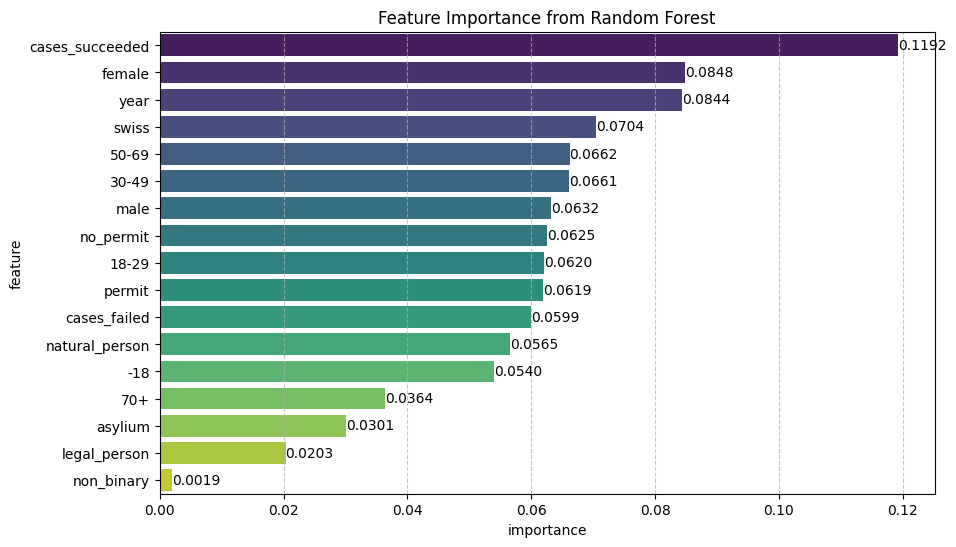

In [ ]:
# Assuming `df` is your DataFrame and 'offence' is the target variable
X = df.iloc[:, 1:-1]  # All features except the 'offence' and 'cases_total' columns
y = df["offence"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 1. Random Forest Feature Importance
importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print(f"Feature importance:")
print(feature_importance_df)

# Plot feature importance with grid and value labels
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add value labels
for index, value in enumerate(feature_importance_df['importance']):
    plt.text(value, index, f'{value:.4f}', va='center')

plt.show()

feature importance v2

Feature importance:
           feature  importance
1           female    0.104155
10           swiss    0.096745
8            50-69    0.092005
7            30-49    0.090690
0             male    0.087618
6            18-29    0.083970
13       no_permit    0.082303
11          permit    0.081719
4   natural_person    0.078809
5              -18    0.075488
9              70+    0.049898
12         asylium    0.044952
3     legal_person    0.028472
2       non_binary    0.003177


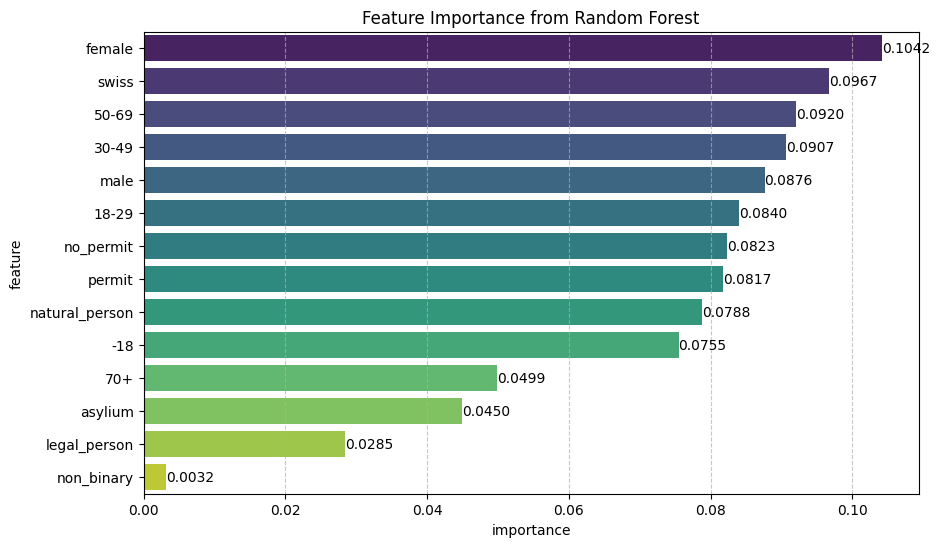

In [ ]:
# Assuming `df` is your DataFrame and 'offence' is the target variable
# Remove the specified columns from the feature set
columns_to_remove = ["cases_succeeded", "year", "cases_failed"]
X = df.drop(columns=columns_to_remove + ['offence', 'cases_total'])  # Remove the specified columns, 'offence', and 'cases_total'
y = df["offence"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# 1. Random Forest Feature Importance
importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print(f"Feature importance:")
print(feature_importance_df)

# Plot feature importance with grid and value labels
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add value labels
for index, value in enumerate(feature_importance_df['importance']):
    plt.text(value, index, f'{value:.4f}', va='center')

plt.show()


If we wanted, we could remove the features that are less than 1% to speed up the training as they have little influence on the prediction.

Let's do some unsupervised learning:

           0    1    2    3    4    5    6     7    8    9     ... 3478 3479  \
male        250    0    0   34    5    0  809  5292    0  637  ...   23    0   
female       38    0    0   13    1    0   93  1115    0  304  ...    6    0   
non_binary    0    0    0    0    0    0    0     0    0    0  ...    0    0   
-18          35    0    0    1    0    0  187   855    0   52  ...    0    0   
18-29       105    0    0   13    3    0  350  1796    0  173  ...    2    0   
30-49       108    0    0   22    3    0  296  2781    0  344  ...   15    0   
50-69        35    0    0    8    0    0   64   862    0  289  ...   11    0   
70+           5    0    0    3    0    0    5   110    0   83  ...    1    0   
swiss       106    0    0   32    2    0  383  2832    0  617  ...   19    0   
permit       86    0    0   11    4    0  318  2470    0  230  ...    6    0   
asylium      34    0    0    1    0    0   98   459    0    9  ...    1    0   
no_permit    62    0    0    3    0    0

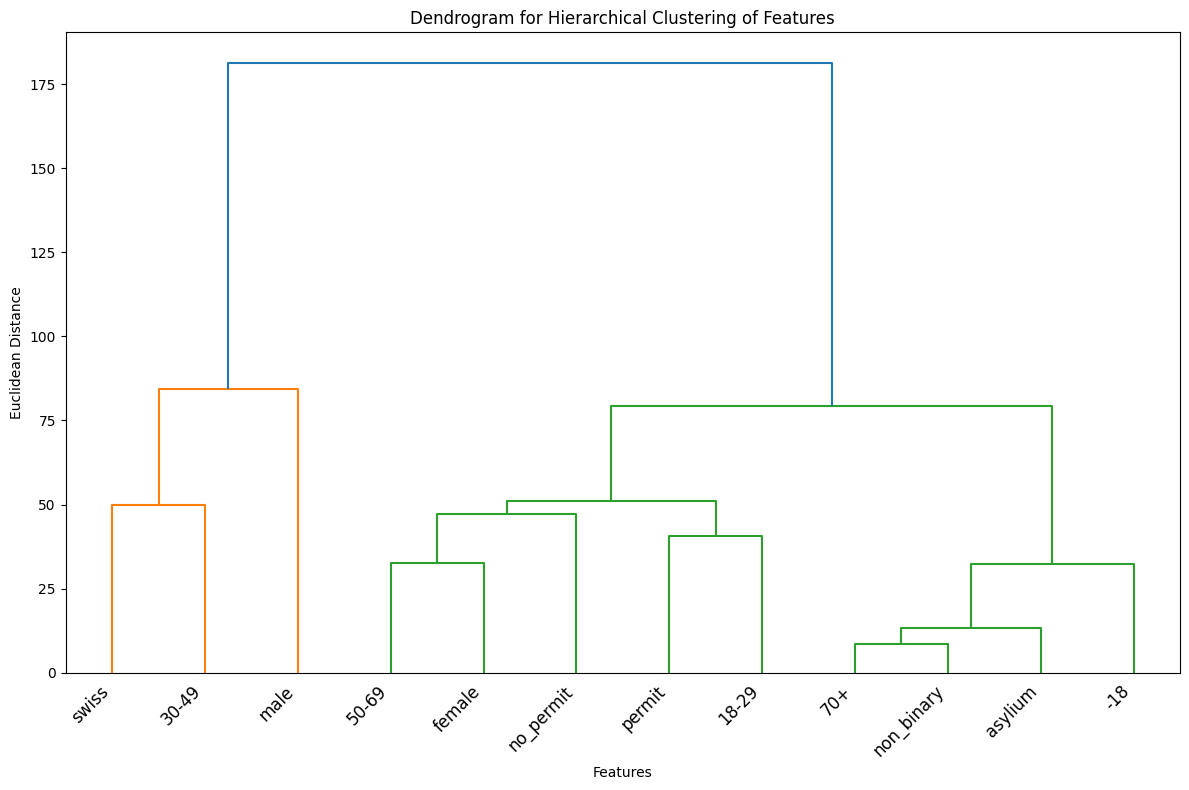

In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Exclude 'offence', 'year', 'cases_total', 'cases_succeeded', and 'cases_failed' columns, then transpose the DataFrame
X = df.drop(columns=['offence', 'year', 'cases_total', 'cases_succeeded', 'cases_failed', 'legal_person', 'natural_person']).T  # Drop the specified columns
print(X)  # Optional: Check the feature set to verify exclusions

# Standardize the transposed data
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Perform hierarchical clustering
linked = linkage(X_scaled, method='ward')  # Using Ward's method for linkage

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linked, orientation='top', labels=X.index, distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram for Hierarchical Clustering of Features')
plt.xlabel('Features')
plt.ylabel('Euclidean Distance')

# Rotate x-axis labels diagonally
plt.xticks(rotation=45, ha='right')

plt.tight_layout()  # Adjust layout to avoid label clipping
plt.show()




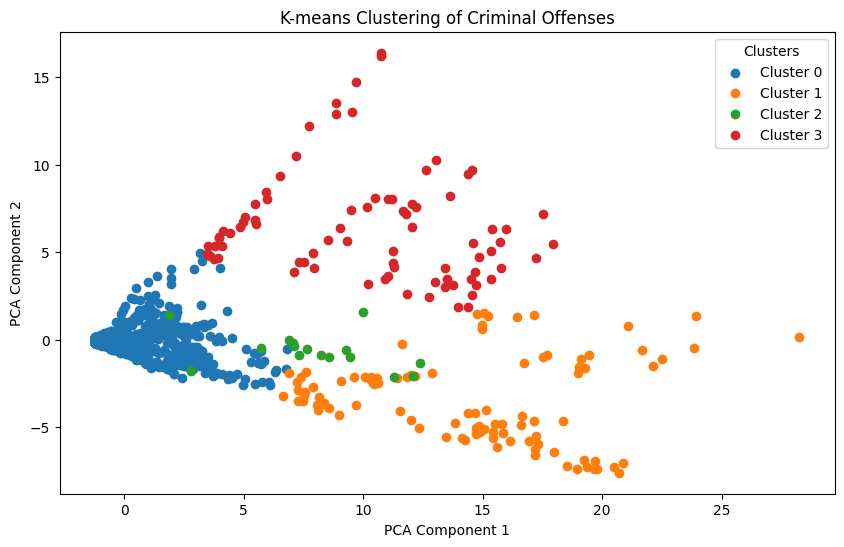


Cluster 0:
Offense Counts: 238
 - Homicides
 - Acts preparatory to the commission of an offence
 - Financing terrorism
 - Attack on the freedom of faith and the freedom to worship
 - Disturbing the peace of the dead
 - Committing an offence while in a state of voluntarily induced mental incapacity
 - Genocide
 - High treason
 - Attacks on the independence of the Confederation
 - Foreign operations and activities directed against the security of Switzerland
 - Diplomatic treason
 - Moving of national boundary markers
 - Violation of Swiss territorial sovereignty
 - Attacks on Swiss national emblems
 - Unlawful activities on behalf of a foreign state
 - Political espionage
 - Industrial espionage
 - Military espionage
 - Attacks on the constitutional order
 - Subversive propaganda
 - Unlawful association
 - Incitement and inducement to violate military duties
 - Forgery of military orders or instructions
 - Disruption of military service
 - Disruption and obstruction of elections and vo

In [ ]:
X = df.iloc[:, 1:-1]  # All features except the 'offence' and 'cases_total' columns
y = df["offence"]

# Feature scaling
sc = StandardScaler()
X = sc.fit_transform(X)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Running K-means with the optimal number of clusters
kmeans = KMeans(n_clusters=4, random_state=42)
cluster = kmeans.fit_predict(X)

# Unique clusters and their labels
unique_clusters = set(cluster)

# Define cluster labels (optional, for display purposes)
cluster_labels = {0: "Cluster 0", 1: "Cluster 1", 2: "Cluster 2", 3: "Cluster 3"}

# Plotting the clusters in PCA-reduced 2D space
plt.figure(figsize=(10, 6))
for cl in unique_clusters:
    plt.scatter(
        X_pca[cluster == cl, 0],
        X_pca[cluster == cl, 1],
        label=cluster_labels.get(cl, f"Cluster {cl}"),
        cmap="viridis"
    )

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-means Clustering of Criminal Offenses")
plt.legend(title="Clusters")
plt.show()

df['cluster'] = cluster  # Add cluster labels to your DataFrame
# Loop through each cluster and print details
for cluster_num in sorted(df['cluster'].unique()):
    print(f"\nCluster {cluster_num}:")

    # Select all rows that belong to the current cluster
    cluster_data = df[df['cluster'] == cluster_num]

    # Print the counts of each offense type within the cluster
    offense_counts = cluster_data['offence'].value_counts()
    print(f"Offense Counts: {len(offense_counts)}")
    for offence in offense_counts.index:
        print(f" - {offence}")


    # Print a separator for clarity
    print("-" * 50)

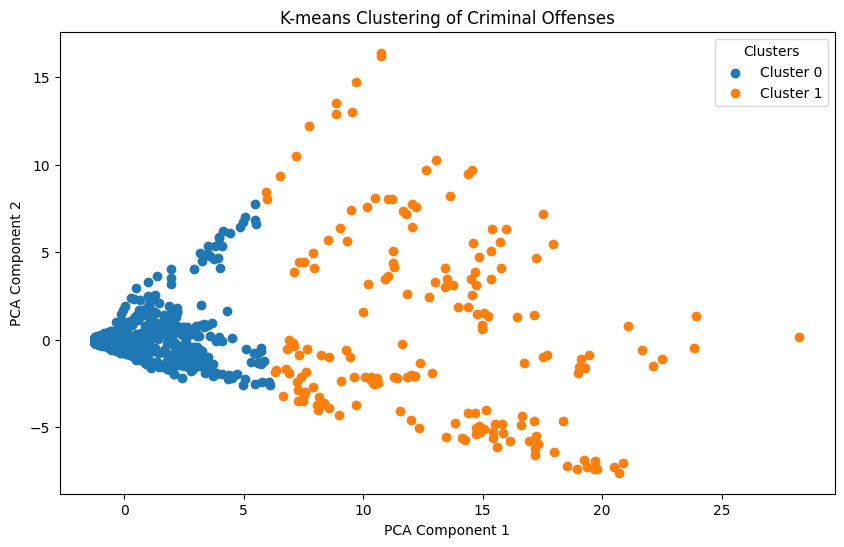


Cluster 0:
Offense Counts: 240
 - Homicides
 - Acts preparatory to the commission of an offence
 - Financing terrorism
 - Attack on the freedom of faith and the freedom to worship
 - Disturbing the peace of the dead
 - Committing an offence while in a state of voluntarily induced mental incapacity
 - Genocide
 - High treason
 - Attacks on the independence of the Confederation
 - Foreign operations and activities directed against the security of Switzerland
 - Diplomatic treason
 - Moving of national boundary markers
 - Violation of Swiss territorial sovereignty
 - Attacks on Swiss national emblems
 - Unlawful activities on behalf of a foreign state
 - Political espionage
 - Industrial espionage
 - Military espionage
 - Attacks on the constitutional order
 - Subversive propaganda
 - Unlawful association
 - Incitement and inducement to violate military duties
 - Forgery of military orders or instructions
 - Disruption of military service
 - Disruption and obstruction of elections and vo

In [ ]:
X = df.iloc[:, 1:-1]  # All features except the 'offence' and 'cases_total' columns
y = df["offence"]

# Feature scaling
sc = StandardScaler()
X = sc.fit_transform(X)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Running K-means with the optimal number of clusters
kmeans = KMeans(n_clusters=2, random_state=42)
cluster = kmeans.fit_predict(X)

# Unique clusters and their labels
unique_clusters = set(cluster)

# Define cluster labels (optional, for display purposes)
cluster_labels = {0: "Cluster 0", 1: "Cluster 1"}

# Plotting the clusters in PCA-reduced 2D space
plt.figure(figsize=(10, 6))
for cl in unique_clusters:
    plt.scatter(
        X_pca[cluster == cl, 0],
        X_pca[cluster == cl, 1],
        label=cluster_labels.get(cl, f"Cluster {cl}"),
        cmap="viridis"
    )

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("K-means Clustering of Criminal Offenses")
plt.legend(title="Clusters")
plt.show()

df['cluster'] = cluster  # Add cluster labels to your DataFrame
# Loop through each cluster and print details
for cluster_num in sorted(df['cluster'].unique()):
    print(f"\nCluster {cluster_num}:")

    # Select all rows that belong to the current cluster
    cluster_data = df[df['cluster'] == cluster_num]

    # Print the counts of each offense type within the cluster
    offense_counts = cluster_data['offence'].value_counts()
    print(f"Offense Counts: {len(offense_counts)}")
    for offence in offense_counts.index:
        print(f" - {offence}")


    # Print a separator for clarity
    print("-" * 50)